# Import

In [1]:
import datetime
import inflection
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
import xgboost as xgb

from boruta import BorutaPy
from IPython.display import Image
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## Funções suporte

In [2]:
def cramerV(x, y):
    cm = pd.crosstab(x, y).values# Confusion matrix
    n = cm.sum()
    r, k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]# scipy.stats
    phi2 = chi2/n
    
    # Bias correction
    phi2corr = max(0, phi2-(k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt(phi2corr/(min(kcorr-1, rcorr-1)))

In [3]:
def mean_percentage_error(y_true, y_pred):
    return np.mean((y_true-y_pred)/y_true)

def ml_error(model_name, y, y_predict):
    mae = mean_absolute_error(y, y_predict)
    mape = mean_absolute_percentage_error(y, y_predict)
    rmse = np.sqrt(mean_squared_error(y, y_predict))
    
    return pd.DataFrame({'model name': model_name,
                        'mae': mae,
                        'mape': mape,
                        'rmse': rmse}, index = [0])

def cross_validation(x_train, kfold, model, model_name, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in range(1, kfold+1):
        if verbose:
            print('kfold: {}'.format(k))
        # Datas
        validation_start = x_train['date'].max()-datetime.timedelta(days = k*6*7)
        validation_end = x_train['date'].max()-datetime.timedelta(days = (k-1)*6*7)
        
        # Filtragem dos dados
        train = x_train[x_train['date'] < validation_start]
        validation = x_train[(x_train['date'] >= validation_start) & (x_train['date'] <= validation_end)]
        
        # Treinamento
        xtrain = train.drop(['date', 'sales'], axis = 1)
        ytrain = train['sales']
        
        # Validação
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']
        
        # Modelo
        m = model.fit(xtrain, ytrain)
        
        # Predição
        y_pred = m.predict(xvalidation)
        
        # Performance
        model_result = ml_error('Linear regression', np.expm1(yvalidation), np.expm1(y_pred))
        
        # Guardar os resultados em listas
        mae_list.append(model_result['mae'].iloc[0])
        mape_list.append(model_result['mape'].iloc[0])
        rmse_list.append(model_result['rmse'].iloc[0])
    
    return pd.DataFrame({'Model': model_name,
                         'MAE CV': str(round(np.mean(mae_list), 2)) + ' +- ' + str(round(np.std(mae_list), 2)),
                         'MAPE CV': str(round(np.mean(mape_list), 2)) + ' +- ' + str(round(np.std(mape_list), 2)),
                         'RMSE CV': str(round(np.mean(rmse_list), 2)) + ' +- ' + str(round(np.std(rmse_list), 2))}, index = [0])

In [4]:
def jupyter_settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 18
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
#     pd.set_option('display.expand_frame_repr', False)
    
#     sns.set()

In [5]:
jupyter_settings()

## Importar dados

In [12]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [50]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1 Descrição dos dados

In [51]:
df1 = df_raw.copy()

## 1.1 Renomear colunas

In [13]:
cols_old = df_raw.columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

In [14]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Dimensão dos dados

In [15]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 1017209
Número de colunas: 18


## 1.3 Tipos dos dados

In [16]:
df1['date'] = pd.to_datetime(df1['date'])

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Tratar os NAs

competition_distance | distance in meters to the nearest competitor store

competition_open_since_<month/year> | the approximate year and month of the time the nearest competitor was opened

promo2_since_<week/year> | the year and calendar week when the store started participating in Promo2

promo_interval | the months the promotion is started anew

In [18]:
# Competition distance | replace with distance larger than previous max
df1['competition_distance'].fillna(200000, inplace = True)

In [19]:
# Competition open since month | replace with moth in date column
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# Competition open since year | replace with year in date column
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

In [20]:
# Promo 2 since week | replace with week in date column
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# Promo 2 since year | replace with year in date column
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

In [21]:
# Promo interval
# Get month of date column in str format
month_str = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['month_str'] = df1['date'].apply(lambda x: month_str[x.month])

# 1: promo active, 0: otherwise
df1['promo_interval'].fillna('-', inplace = True)
df1['promo2_active'] = df1.apply(lambda x: 1 if x['month_str'] in x['promo_interval'].split(',') else 0, axis = 1)

In [22]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_str                       0
promo2_active                   0
dtype: int64

## 1.5 Tipos dos dados

In [23]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_str                               object
promo2_active                            int64
dtype: object

## 1.6 Estatística descritiva

In [25]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 Atributos numéricos

In [26]:
# Tendência central - média, mediana
tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
tc2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(min)).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d4 = pd.DataFrame(num_attributes.apply(np.std)).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Contatenar
m = pd.concat([d1, d2, d3, tc1, tc2, d4, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [27]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.6.2 Atributos categóricos

In [28]:
cat_attributes.apply(lambda x: len(x.unique()))

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_str         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

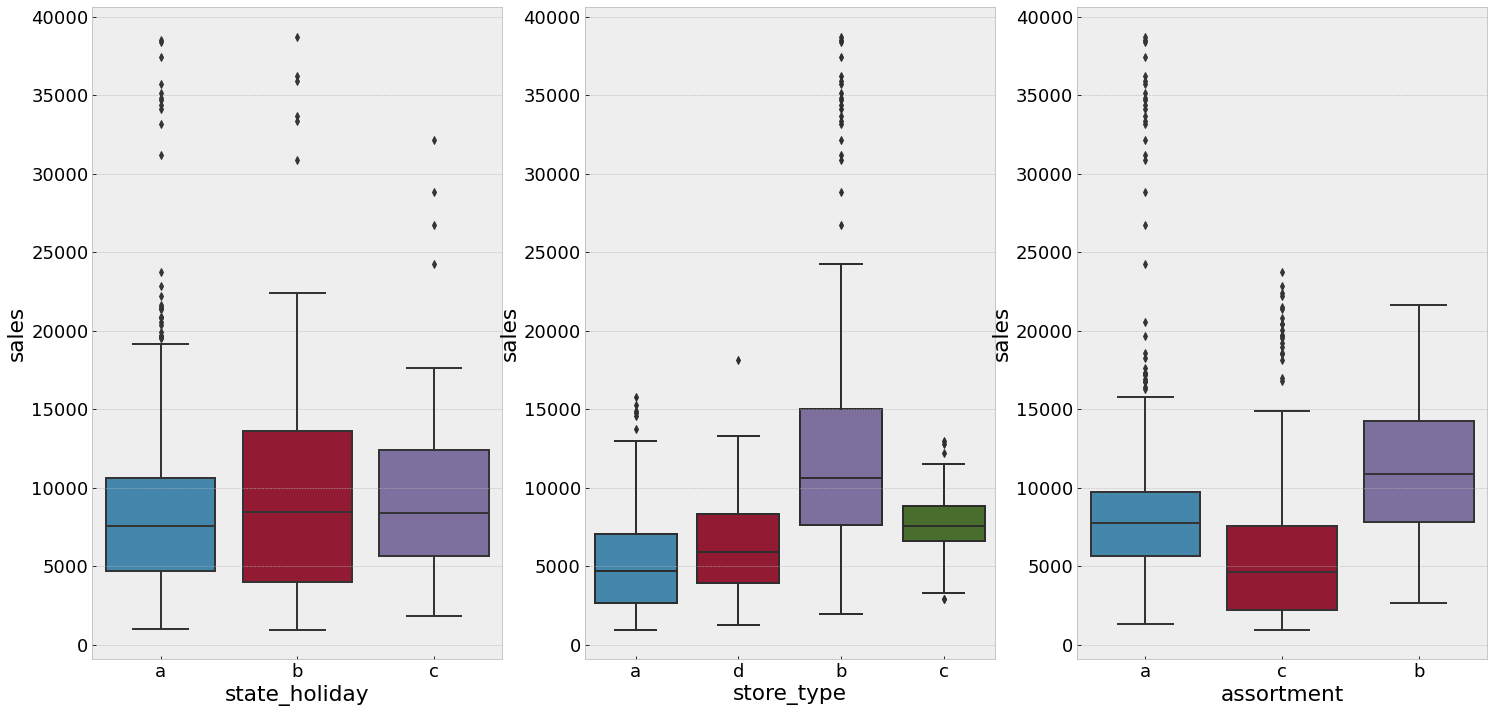

In [29]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

# 2 Feature engineering

In [30]:
df2 = df1.copy()

## 2.1 Mapa de hipóteses

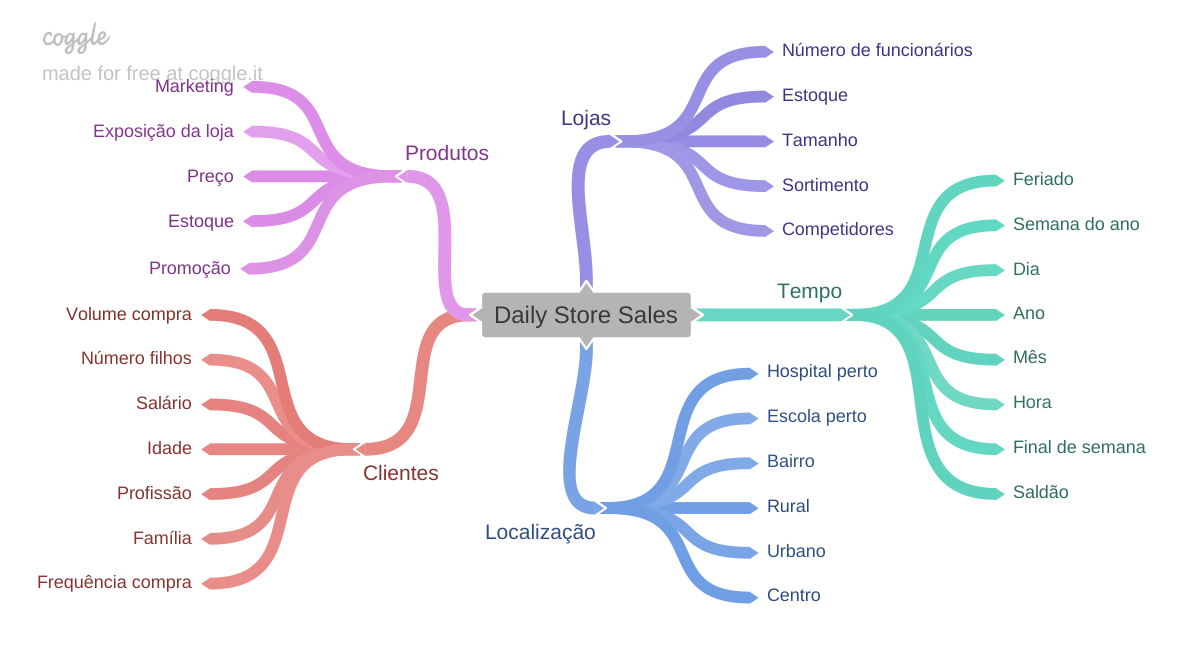

In [31]:
Image('img/HypothesisMindMap.png')

## 2.2 Criação das hipóteses

### 2.2.1 Sobre a loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores mais antigos deveriam vender mais.

### 2.2.2 Sobre os produtos

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de vitrine deveriam vender mais.

**3.** Lojas com menores preços deveriam vender mais.

**4.** Lojas com promoções mais agressivas (maiores descontos) deveriam vender mais.

**5.** Lojas com promoções mais longas deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Sobre o tempo

**1.** Lojas abertas durante o natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre.

**4.** Lojas deveriam vender mais até o dia 10 de cada mês.

**5.** Lojas deveriam vender menos nos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Prioridade das hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores mais antigos deveriam vender mais.

**4.** Lojas com promoções mais longas deveriam vender mais.

**5.** Lojas com mais promoções consecutivas deveriam vender mais.

**6.** Lojas abertas durante o natal deveriam vender mais.

**7.** Lojas deveriam vender mais ao longo dos anos.

**8.** Lojas deveriam vender mais no segundo semestre.

**9.** Lojas deveriam vender mais até o dia 10 de cada mês.

**10.** Lojas deveriam vender menos nos finais de semana.

**11.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Criação das variáveis

In [32]:
# Ano
df2['year'] = df2['date'].apply(lambda x: x.year)

# Mês
df2['month'] = df2['date'].apply(lambda x: x.month)

# Dia
df2['day'] = df2['date'].apply(lambda x: x.day)

# Semana
df2['week_of_year'] = df2['date'].apply(lambda x: x.weekofyear)

# Data | ano-semana
df2['year_week'] = df2['date'].apply(lambda x: x.strftime('%Y-%W'))

In [33]:
# Competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])).apply(lambda x: x.days/30).astype('int64')

In [34]:
# Promo since
df2['promo2_since'] = df2['promo2_since_year'].astype('str')+'-'+df2['promo2_since_week'].astype('str')
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%W'))
df2['promo_time_week'] = (df2['date']-df2['promo2_since']).apply(lambda x: x.days/7).astype('int64')

In [35]:
# Assortment | a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# State holiday | a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day')

# 3 Filtragem de variáveis

In [36]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [37]:
df3 = df3[(df3['open'] == 1) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [38]:
drop_cols = ['customers', 'open', 'promo_interval', 'month_str']
df3.drop(drop_cols, axis = 1, inplace = True)

# 4 Análise exploratória de dados

In [39]:
df4 = df3.copy()

## 4.1 Análise univariada

### 4.1.1 Variável resposta

<AxesSubplot:xlabel='sales', ylabel='Count'>

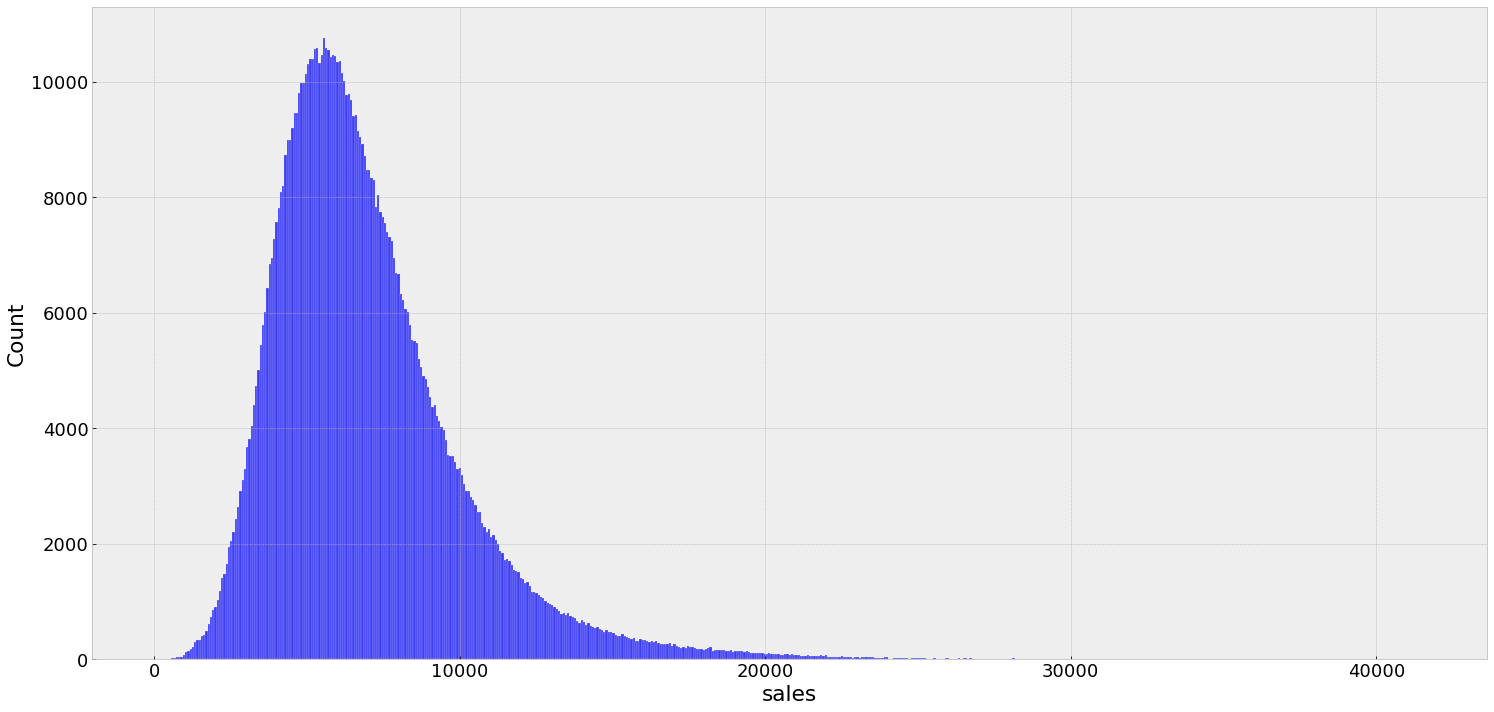

In [40]:
sns.histplot(df4['sales'], kde = False)

### 4.1.2 Variáveis numéricas

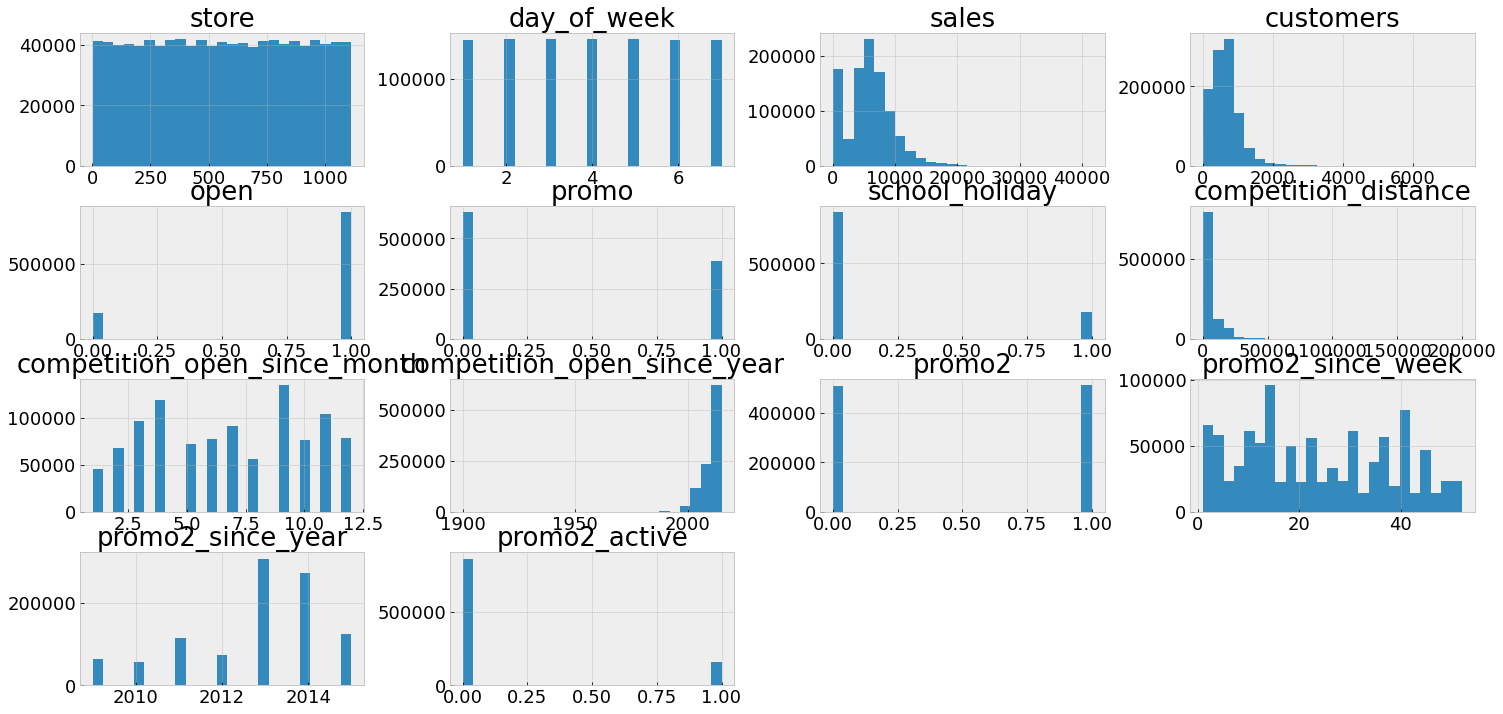

In [41]:
num_attributes.hist(bins = 25);

### 4.1.3 Variáveis categóricas

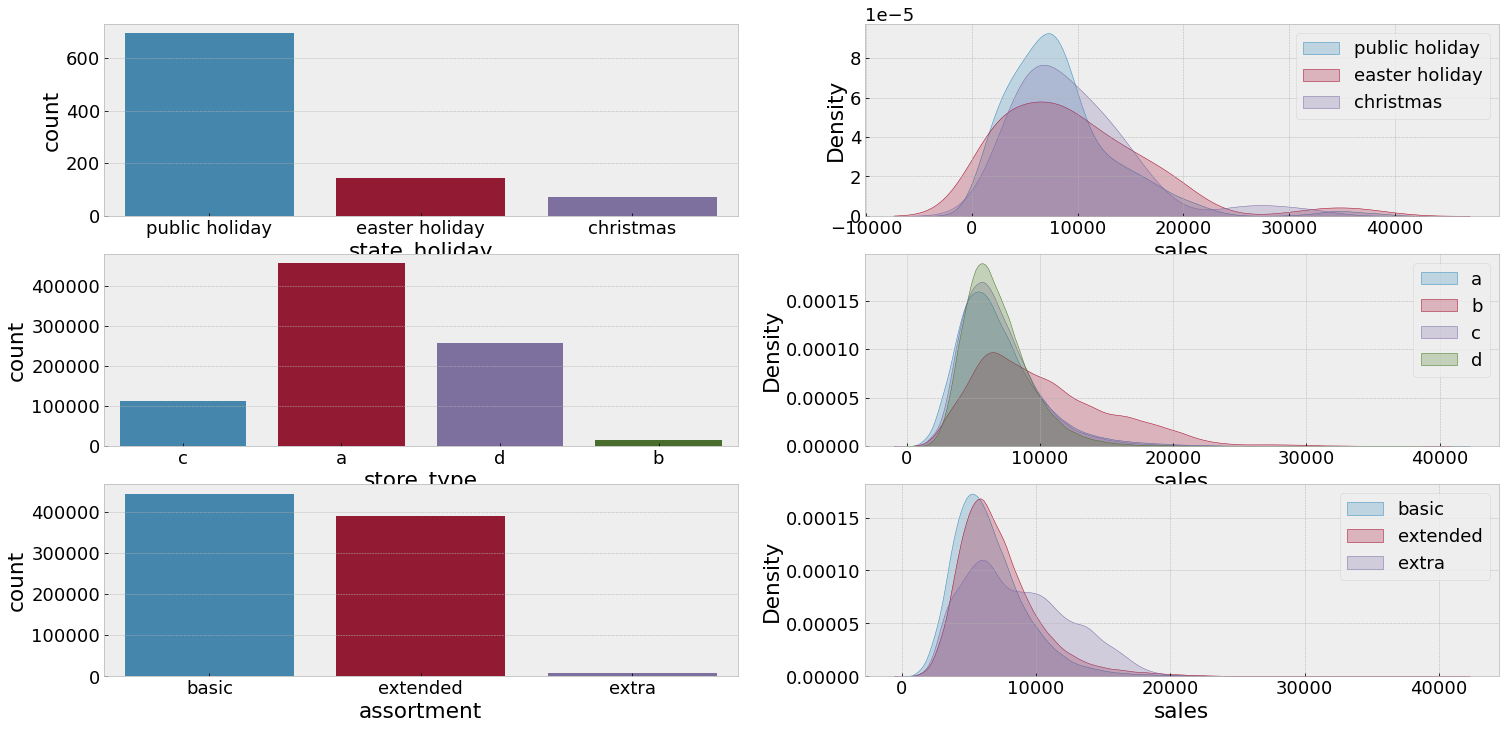

In [42]:
# State holiday
plt.subplot(3, 2, 1)
sns.countplot(x = 'state_holiday', data = df4[df4['state_holiday'] != 'regular day'])

plt.subplot(3, 2, 2)
sns.kdeplot(x = 'sales', data = df4[df4['state_holiday'] == 'public holiday'], label = 'public holiday', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['state_holiday'] == 'easter holiday'], label = 'easter holiday', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['state_holiday'] == 'christmas'], label = 'christmas', shade = True)
plt.legend()

# Store type
plt.subplot(3, 2, 3)
sns.countplot(x = 'store_type', data = df4)

plt.subplot(3, 2, 4)
sns.kdeplot(x = 'sales', data = df4[df4['store_type'] == 'a'], label = 'a', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['store_type'] == 'b'], label = 'b', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['store_type'] == 'c'], label = 'c', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['store_type'] == 'd'], label = 'd', shade = True)
plt.legend()

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(x = 'assortment', data = df4)

plt.subplot(3, 2, 6)
sns.kdeplot(x = 'sales', data = df4[df4['assortment'] == 'basic'], label = 'basic', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['assortment'] == 'extended'], label = 'extended', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['assortment'] == 'extra'], label = 'extra', shade = True)
plt.legend()

## 4.2 Análise bivariada

### 4.2.1 H1: Lojas com maior sortimento deveriam vender mais.
**Falso:** lojas com maior sortimento vendem menos

<AxesSubplot:xlabel='assortment', ylabel='sales'>

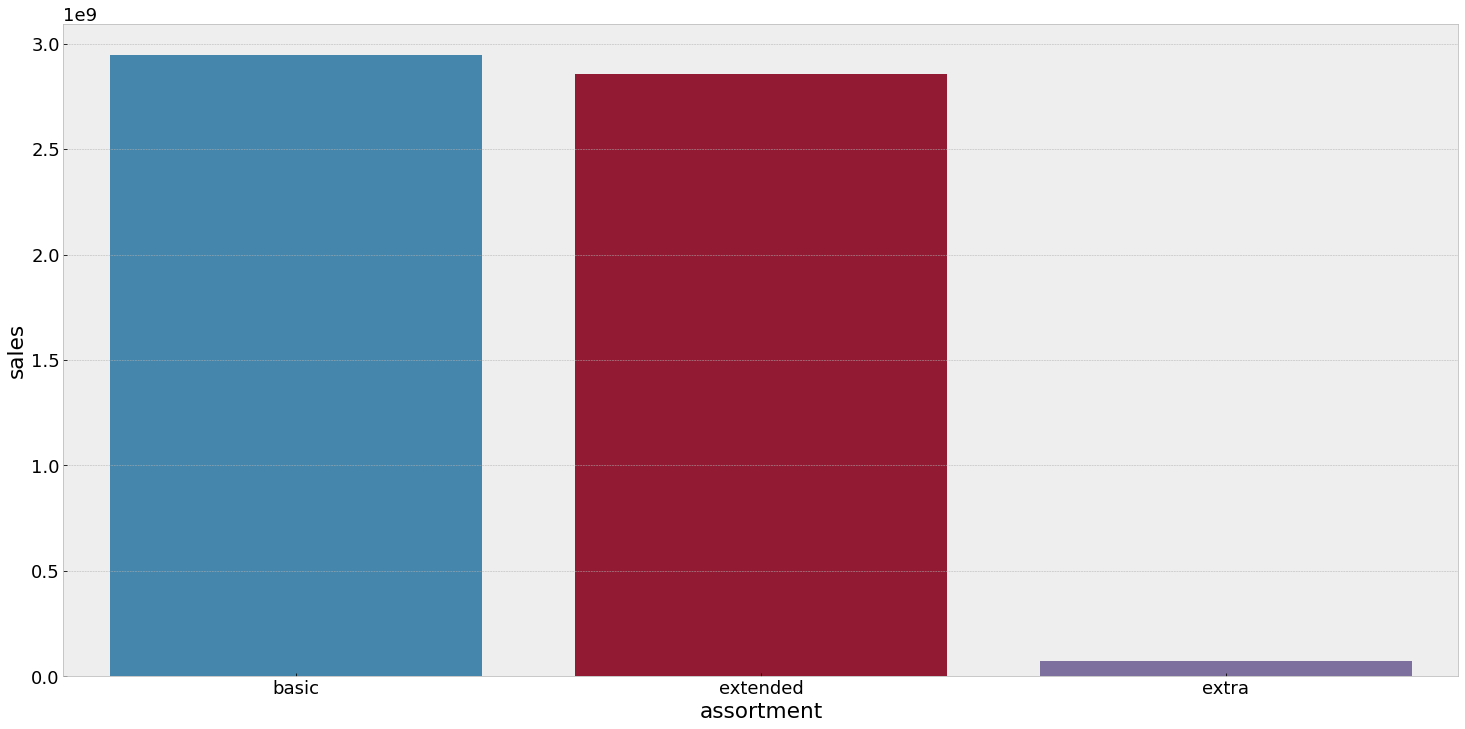

In [43]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

<AxesSubplot:xlabel='year_week'>

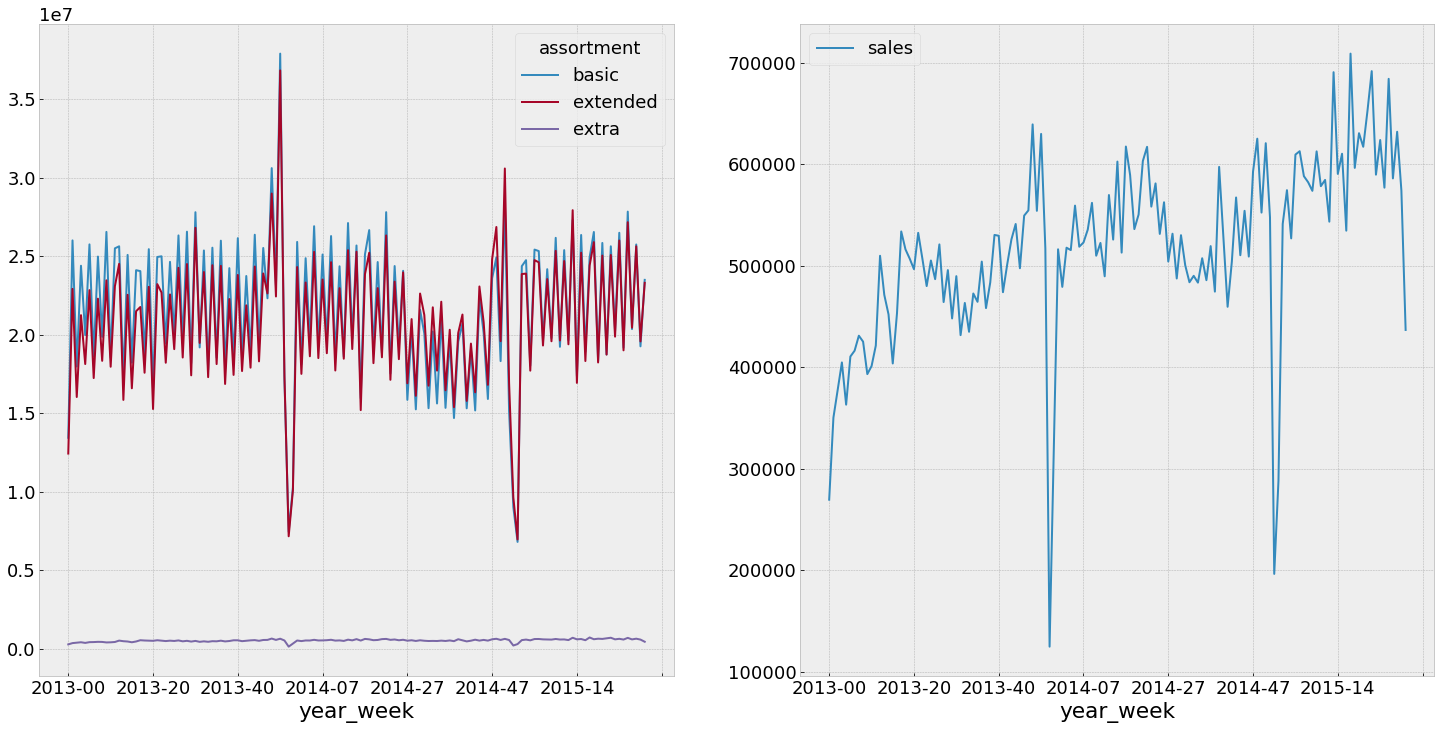

In [44]:
ax = plt.subplot(1, 2, 1)
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot(ax = ax)

ax2 = plt.subplot(1, 2, 2)
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.set_index('year_week').plot(ax = ax2)

### 4.2.2 H2: Lojas com competidores mais próximos deveriam vender menos.
**Falso:** lojas com competidores mais próximos vendem mais

<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

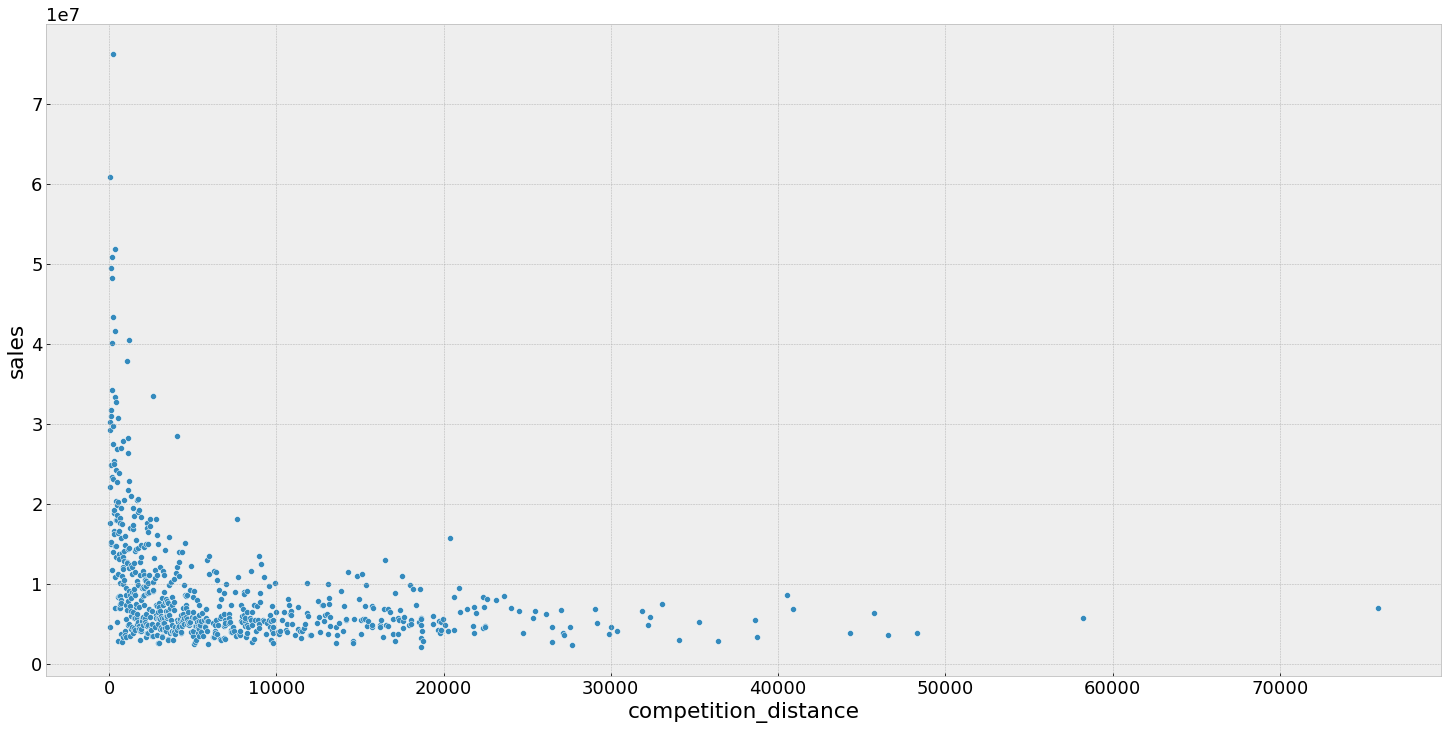

In [45]:
aux1 = df4[df4['competition_distance'] < 200000][['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

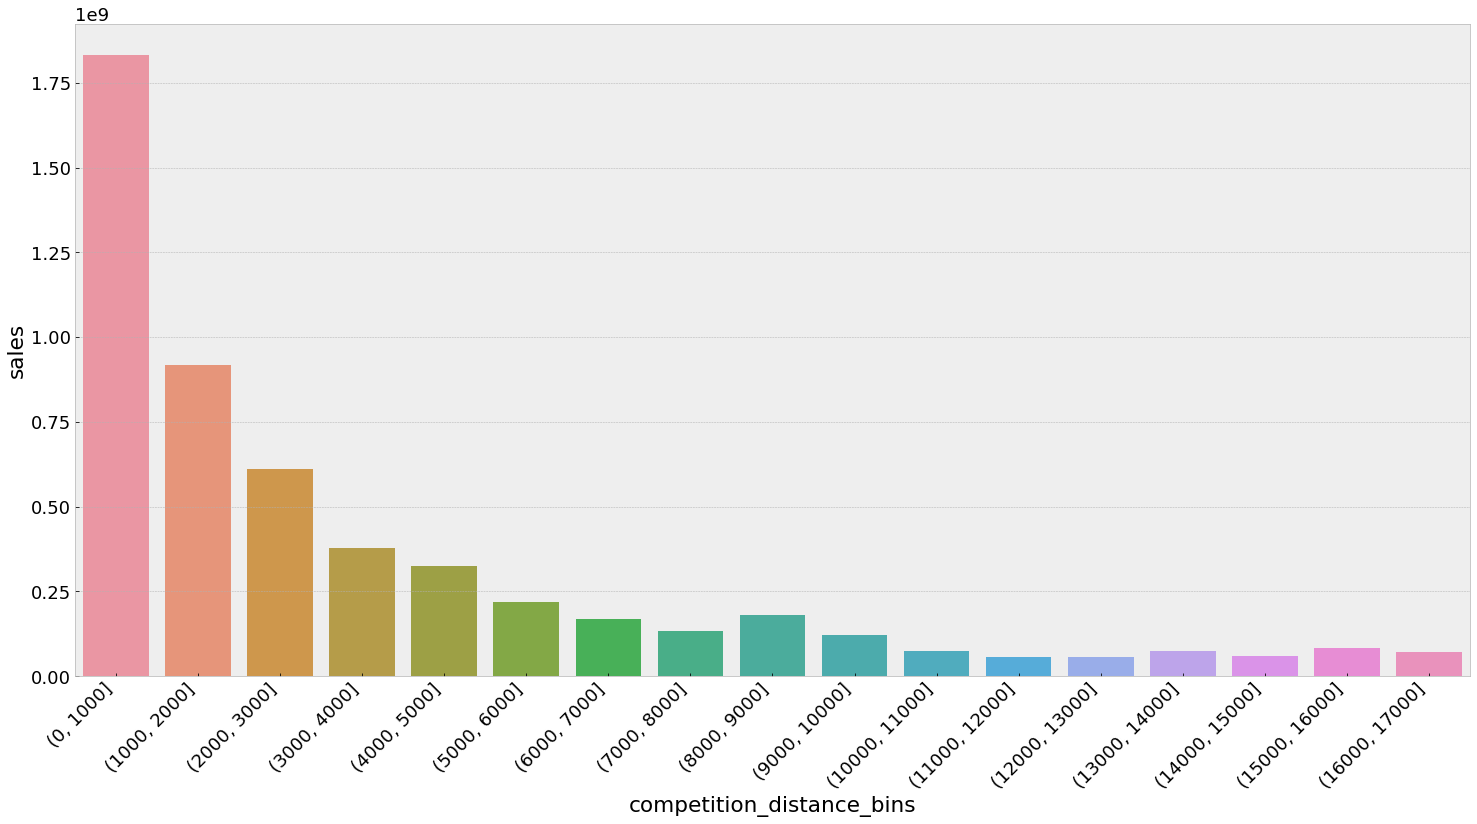

In [46]:
aux1 = df4[df4['competition_distance'] < 200000][['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = range(0, 18000, 1000)# Max distance 75860 m
aux1['competition_distance_bins'] = pd.cut(aux1['competition_distance'], bins)
aux2 = aux1.groupby('competition_distance_bins').sum().reset_index()
sns.barplot(x = 'competition_distance_bins', y = 'sales', data = aux2)
plt.xticks(rotation = 45, horizontalalignment = 'right');

### 4.2.3 H3: Lojas com competidores mais antigos deveriam vender mais.
**Falso:** lojas com competidores mais antigos vendem menos

<AxesSubplot:xlabel='competition_time_month', ylabel='sales'>

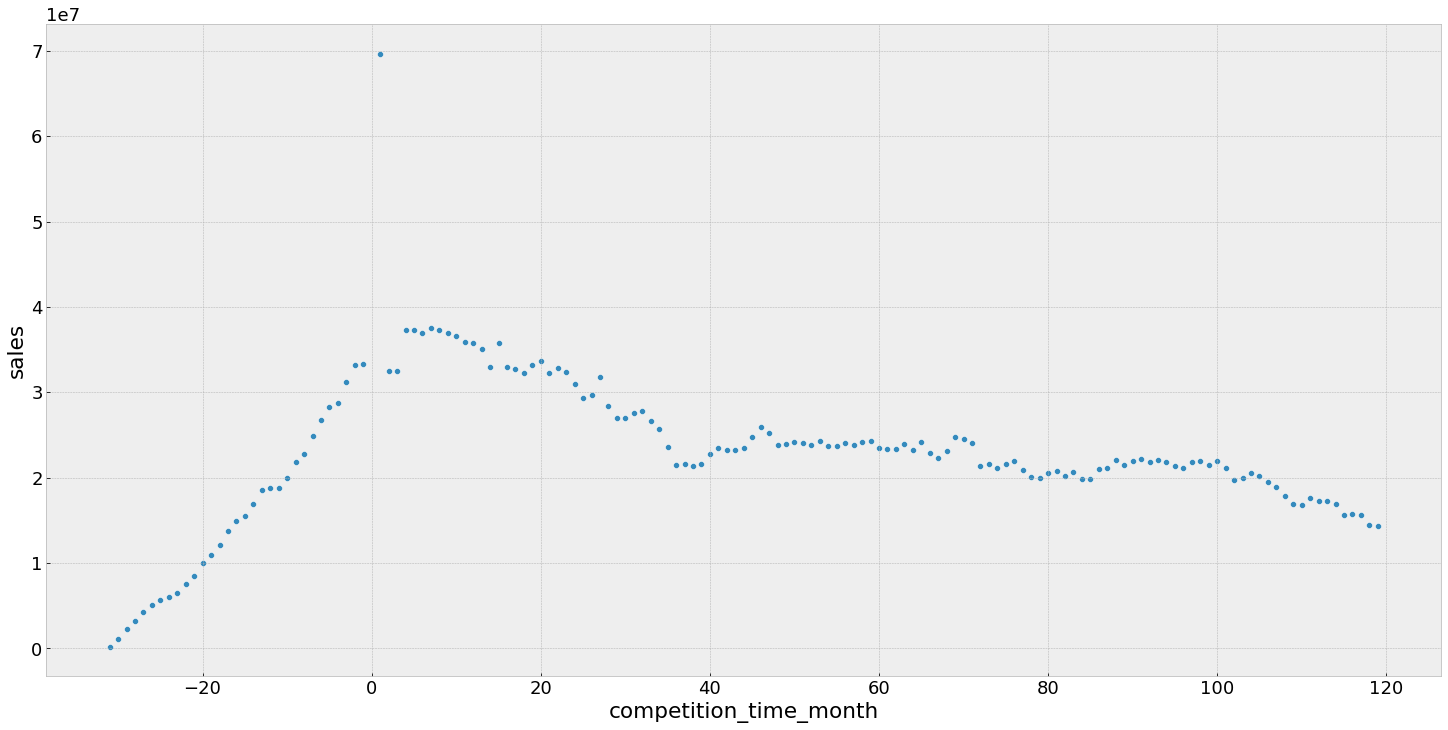

In [47]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] != 0 ) & (aux1['competition_time_month'] < 120)]
sns.scatterplot(x = 'competition_time_month', y = 'sales', data = aux2)

### 4.2.4 H4: Lojas com promoções mais longas deveriam vender mais.
**Falso:** a promoção aumenta as vendas por um período limitado

<AxesSubplot:xlabel='promo_time_week', ylabel='sales'>

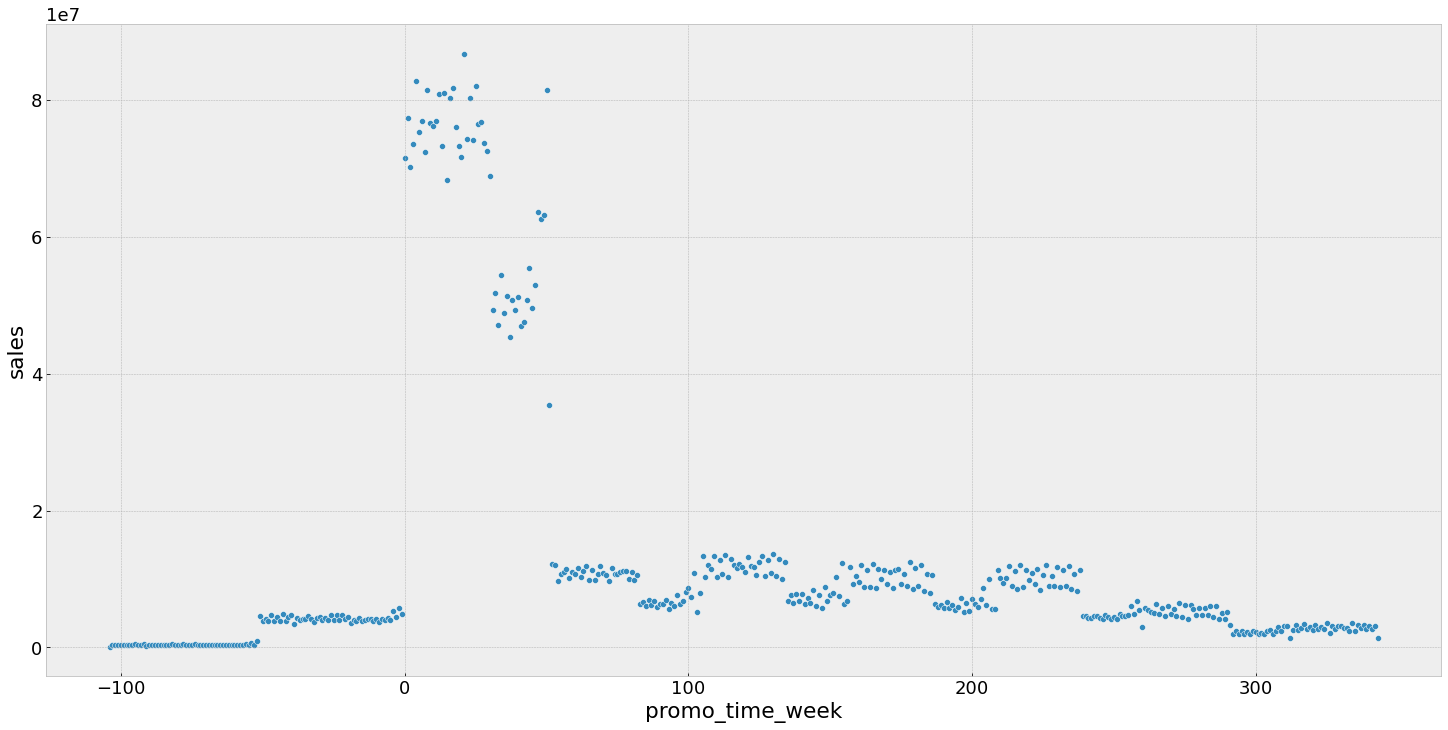

In [48]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
sns.scatterplot(x = 'promo_time_week', y = 'sales', data = aux1)

<AxesSubplot:xlabel='promo_time_week', ylabel='sales'>

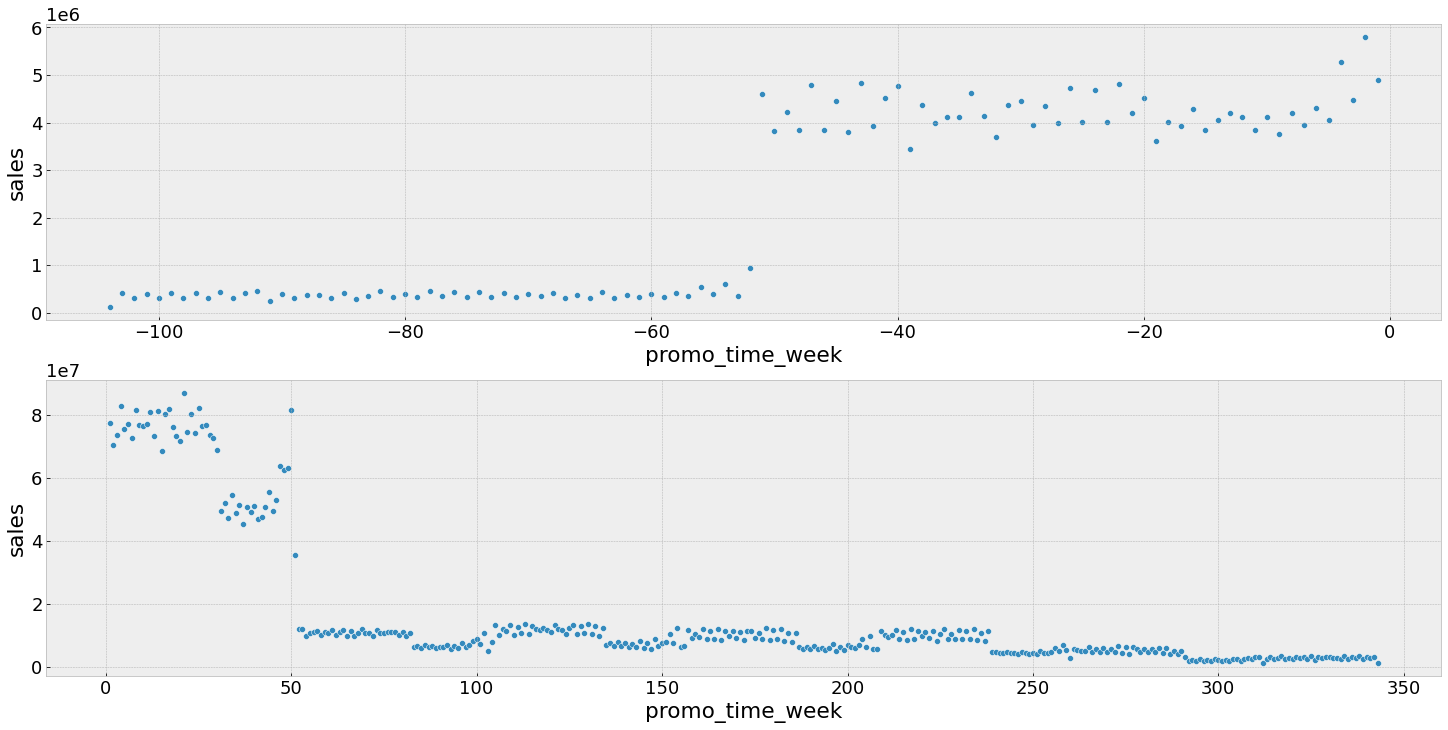

In [49]:
aux2 = aux1[aux1['promo_time_week'] < 0]# promoção regular
aux3 = aux1[aux1['promo_time_week'] > 0]# promoção extendida

plt.subplot(2, 1, 1)
sns.scatterplot(x = 'promo_time_week', y = 'sales', data = aux2)

plt.subplot(2, 1, 2)
sns.scatterplot(x = 'promo_time_week', y = 'sales', data = aux3)

### 4.2.5 H5: Lojas com mais promoções consecutivas deveriam vender mais.
**Falso:** lojas apenas com a promoção regular vendem mais

<AxesSubplot:xlabel='promo2', ylabel='promo'>

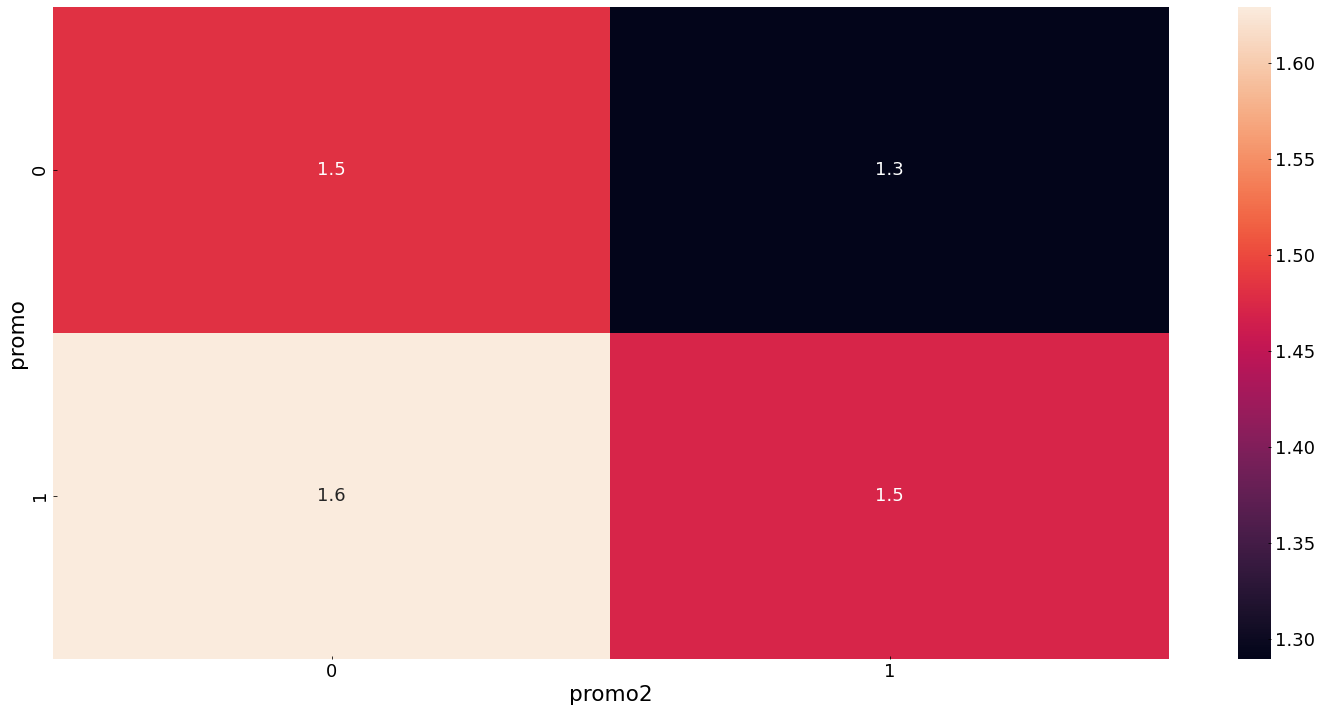

In [50]:
aux1 = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()
aux1['sales'] = aux1['sales'].apply(lambda x: x/1e9)# Volume de vendas em bilhões
aux2 = aux1.pivot_table(index = 'promo', columns = 'promo2', values = 'sales')
sns.heatmap(aux2, annot = True)

<AxesSubplot:xlabel='year_week'>

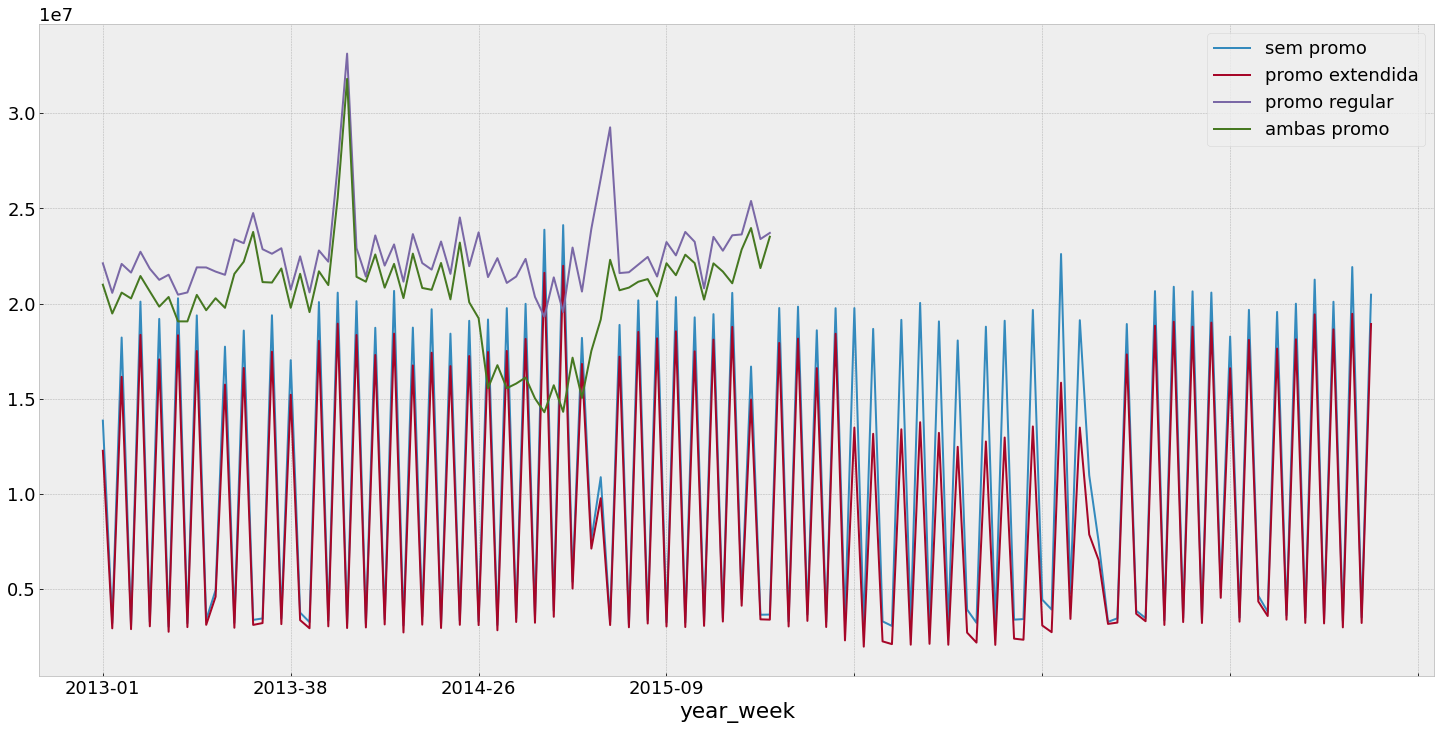

In [51]:
aux1 = df4[(df4['promo'] == 0) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
# aux1['year_week'] = aux1['year_week'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%W'))
ax = aux1.plot(x = 'year_week', y = 'sales', label = 'sem promo')
aux1.dtypes
aux2 = df4[(df4['promo'] == 0) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax, x = 'year_week', y = 'sales', label = 'promo extendida')

aux3 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux3.plot(ax = ax, x = 'year_week', y = 'sales', label = 'promo regular')

aux4 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux4.plot(ax = ax, x = 'year_week', y = 'sales', label = 'ambas promo')

### 4.2.6 H6: Lojas abertas durante o natal deveriam vender mais que outros feriados.
**Falso:** as vendas no natal são menores que em outros feriados

In [52]:
df4['state_holiday'].unique()

array(['regular day', 'public holiday', 'easter holiday', 'christmas'],
      dtype=object)

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

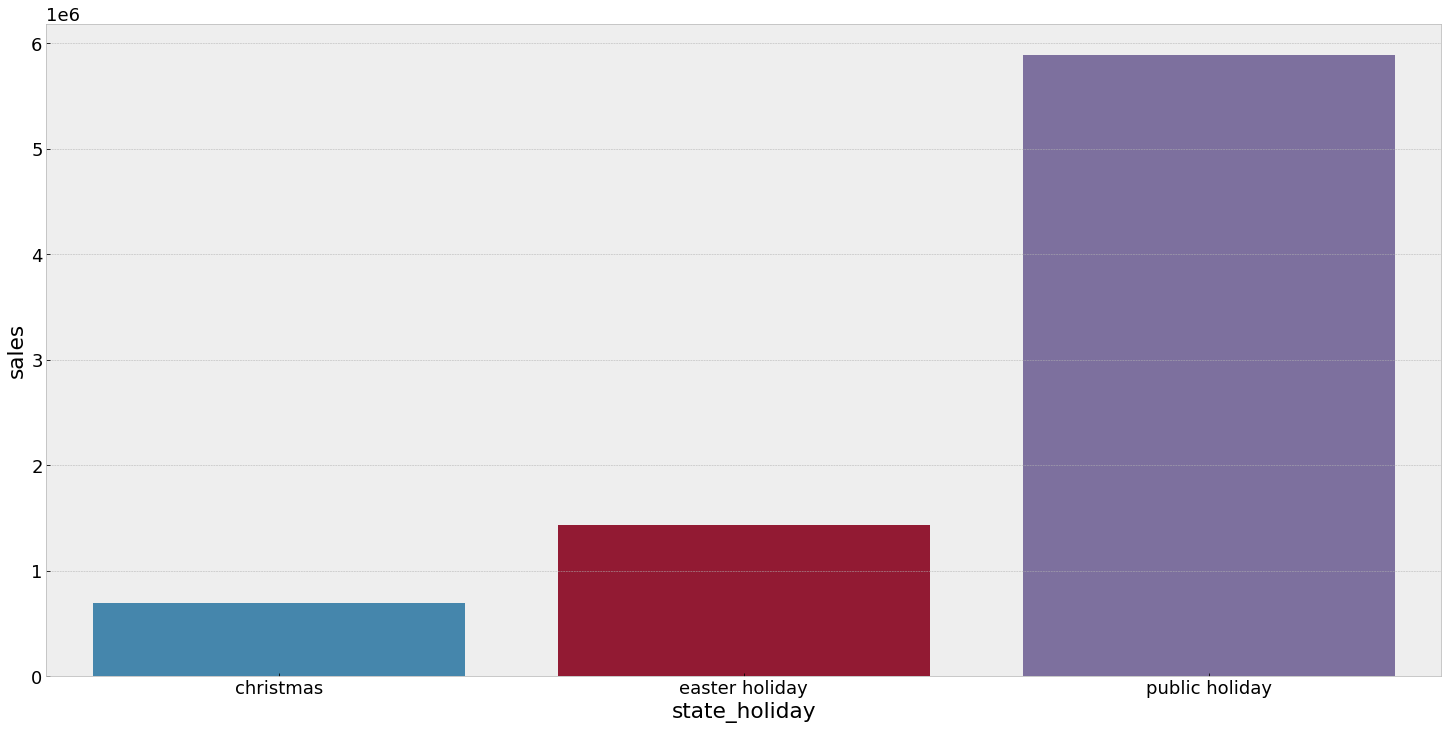

In [53]:
aux1 = df4[df4['state_holiday'] != 'regular day'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1)

<AxesSubplot:xlabel='year', ylabel='sales'>

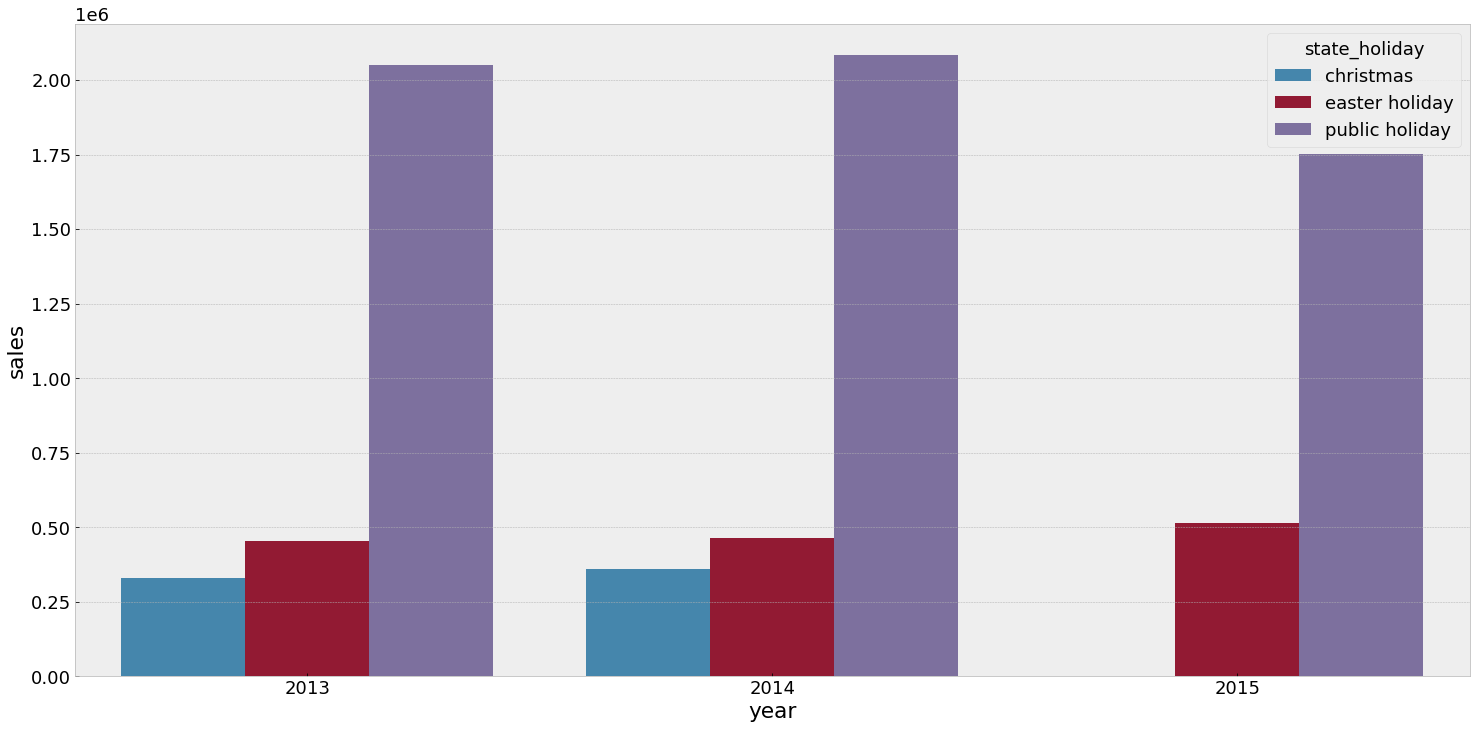

In [54]:
aux1 = df4[df4['state_holiday'] != 'regular day'][['state_holiday', 'year', 'sales']].groupby(['state_holiday', 'year']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux1)

### 4.2.7 H7: Lojas deveriam vender mais ao longo dos anos.
**Falso:** as vendas diminuíram nos últimos anos; as vendas até agosto aumentaram em 2015

<AxesSubplot:xlabel='year', ylabel='sales'>

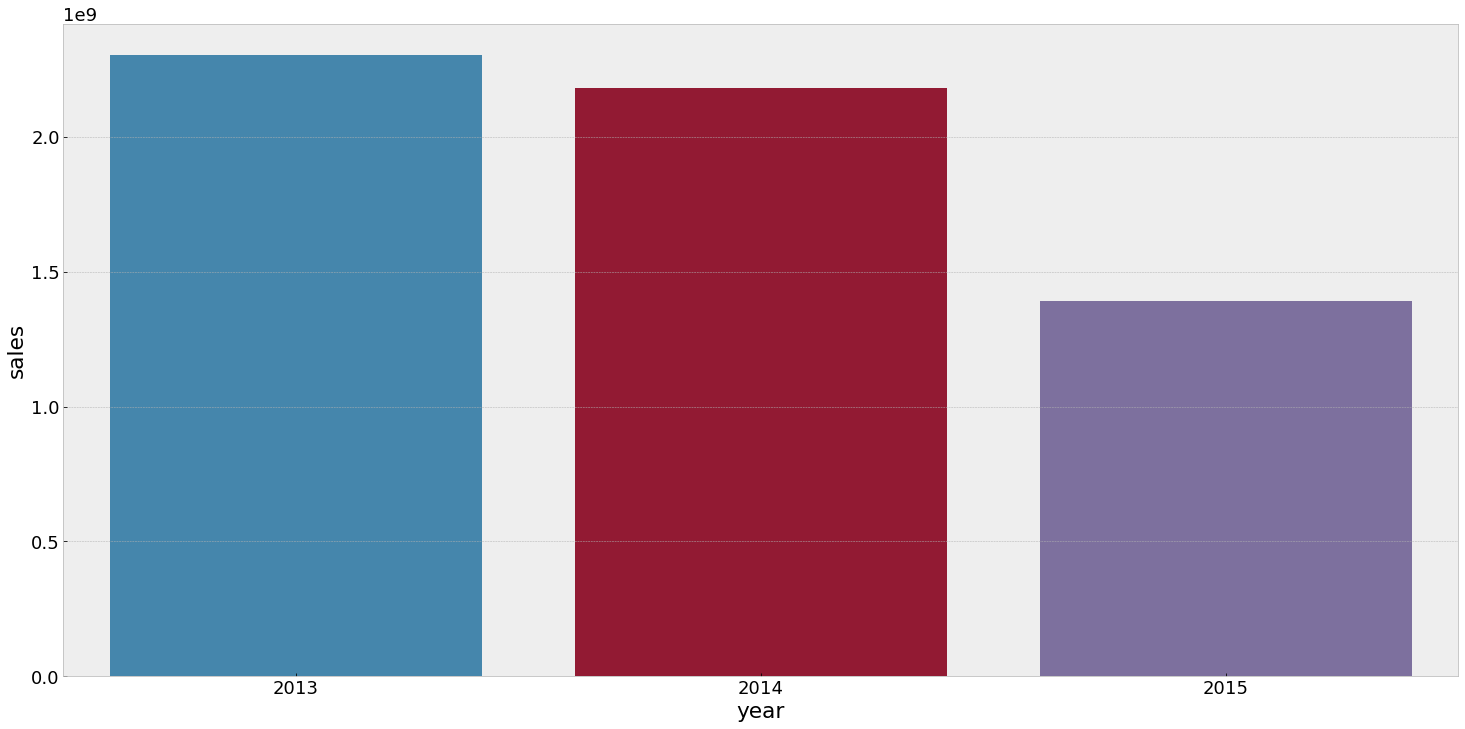

In [55]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux1)

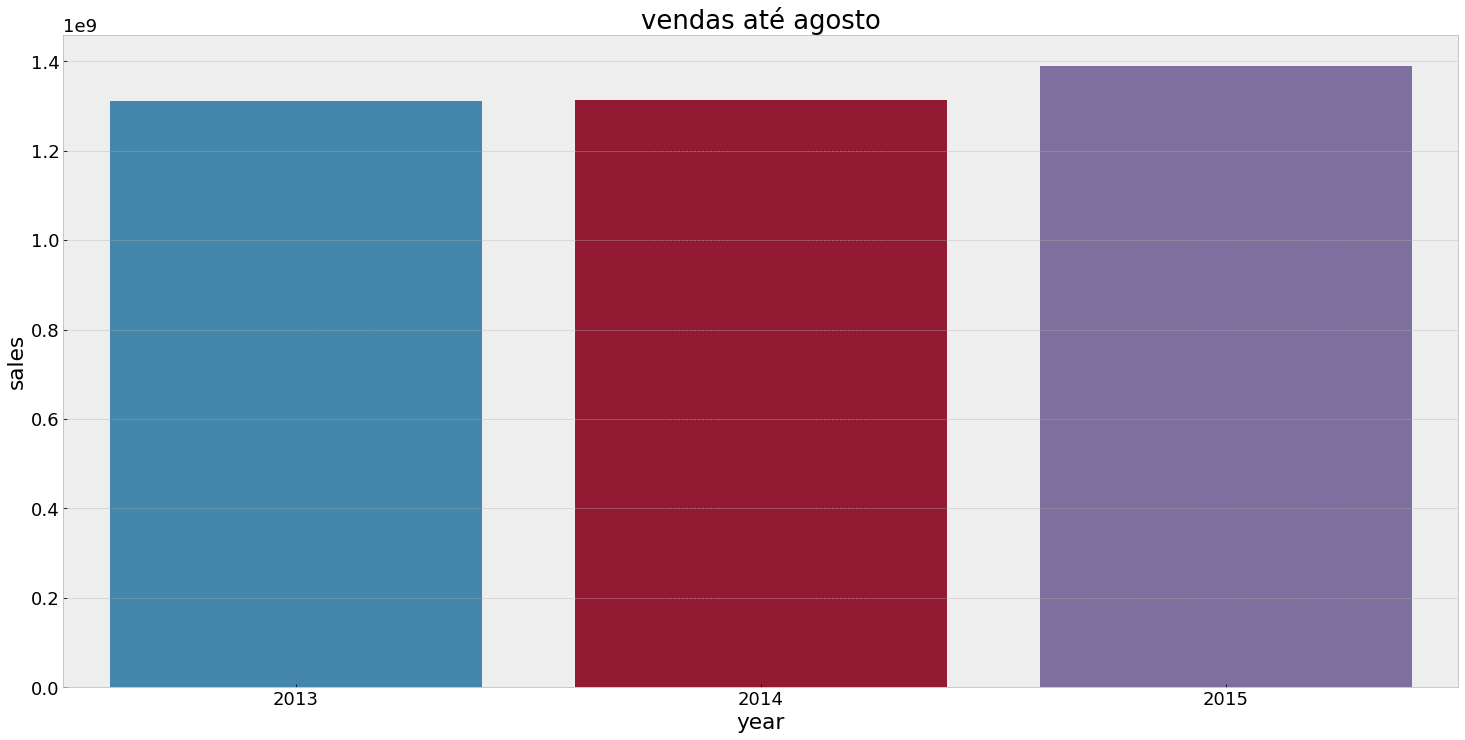

In [56]:
aux1 = df4[df4['month'] < 8][['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux1)
plt.title('vendas até agosto');

### 4.2.8 H8: Lojas deveriam vender mais no segundo semestre.
**Falso:** lojas vendem menos no segundo semestre

<AxesSubplot:>

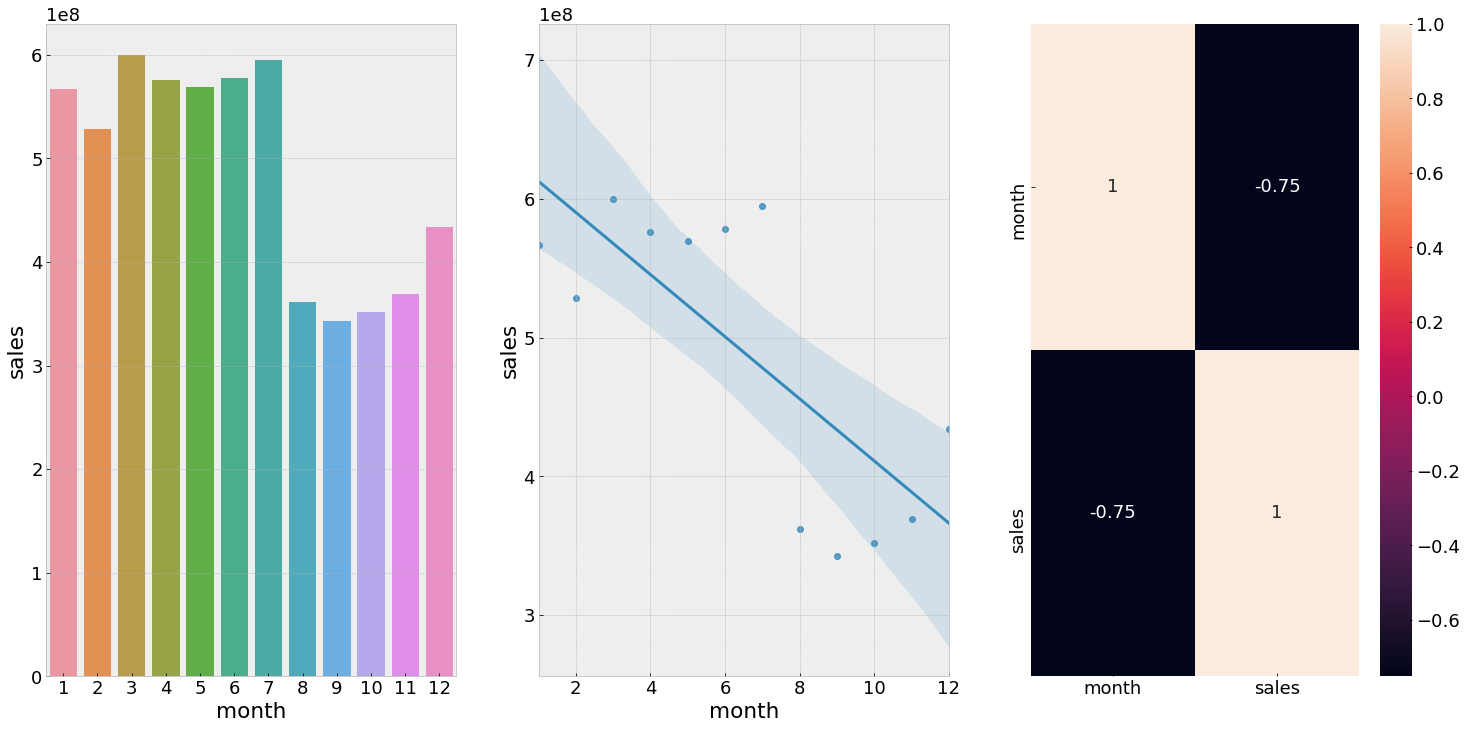

In [57]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### 4.2.9 H9: Lojas deveriam vender mais até o dia 10 de cada mês.
**Falso:** lojas vendem menos até o dia 10 de cada mês

<AxesSubplot:xlabel='day', ylabel='sales'>

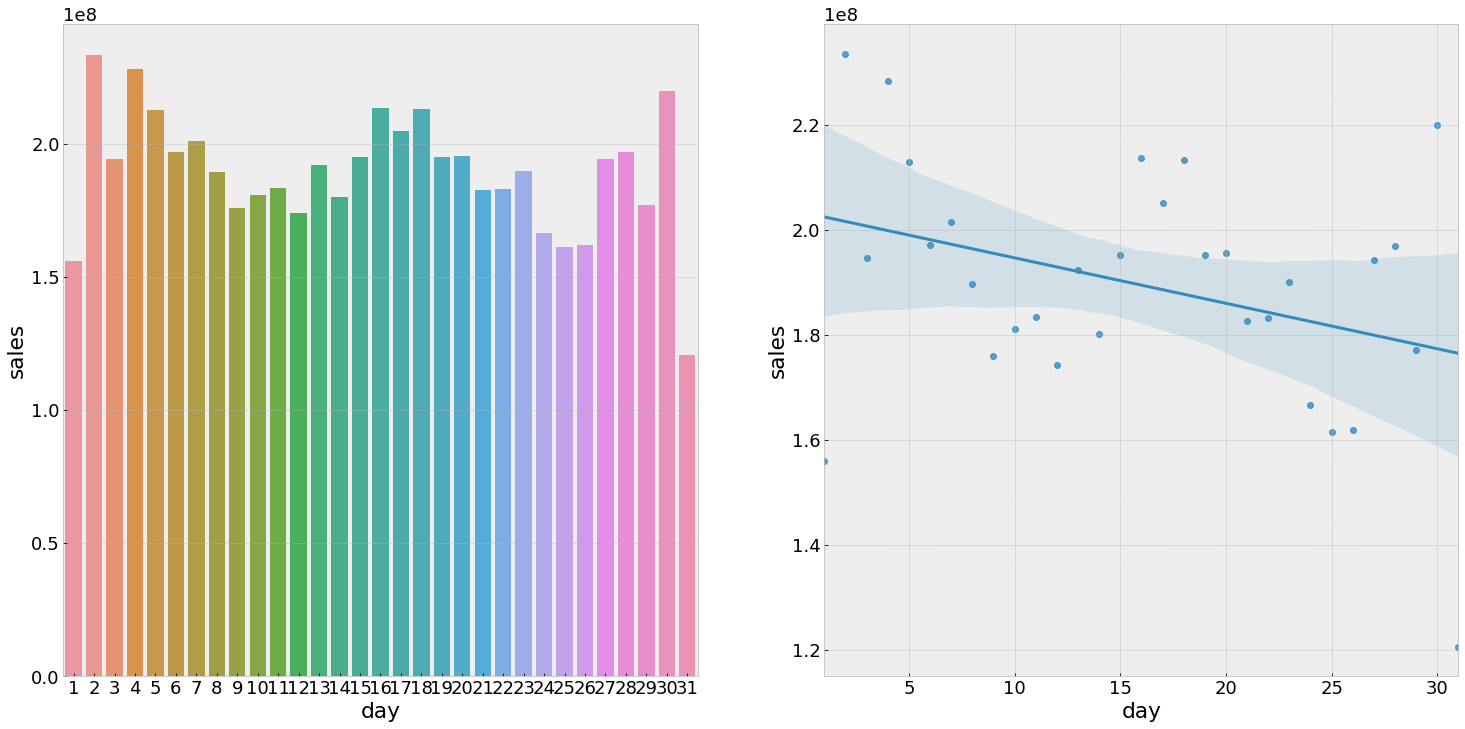

In [58]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(1, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1)

<AxesSubplot:xlabel='after_10', ylabel='sales'>

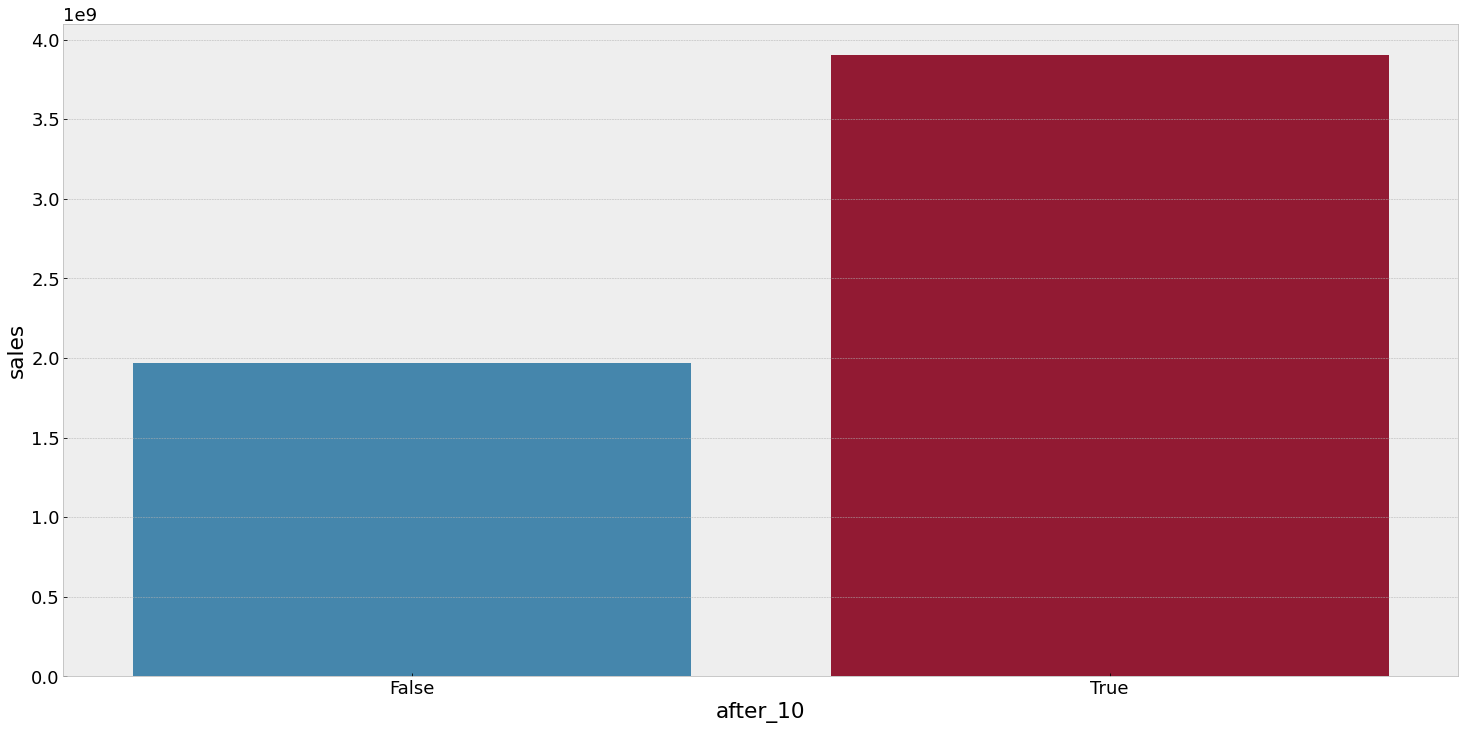

In [59]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
aux1['after_10'] = aux1['day'].apply(lambda x: True if x > 10 else False)
aux2 = aux1.groupby('after_10').sum().reset_index()
sns.barplot(x = 'after_10', y = 'sales', data = aux2)

### 4.2.10 H10: Lojas deveriam vender menos nos finais de semana.
**Verdadeiro:** lojas vendem menos nos finais de semana

<AxesSubplot:>

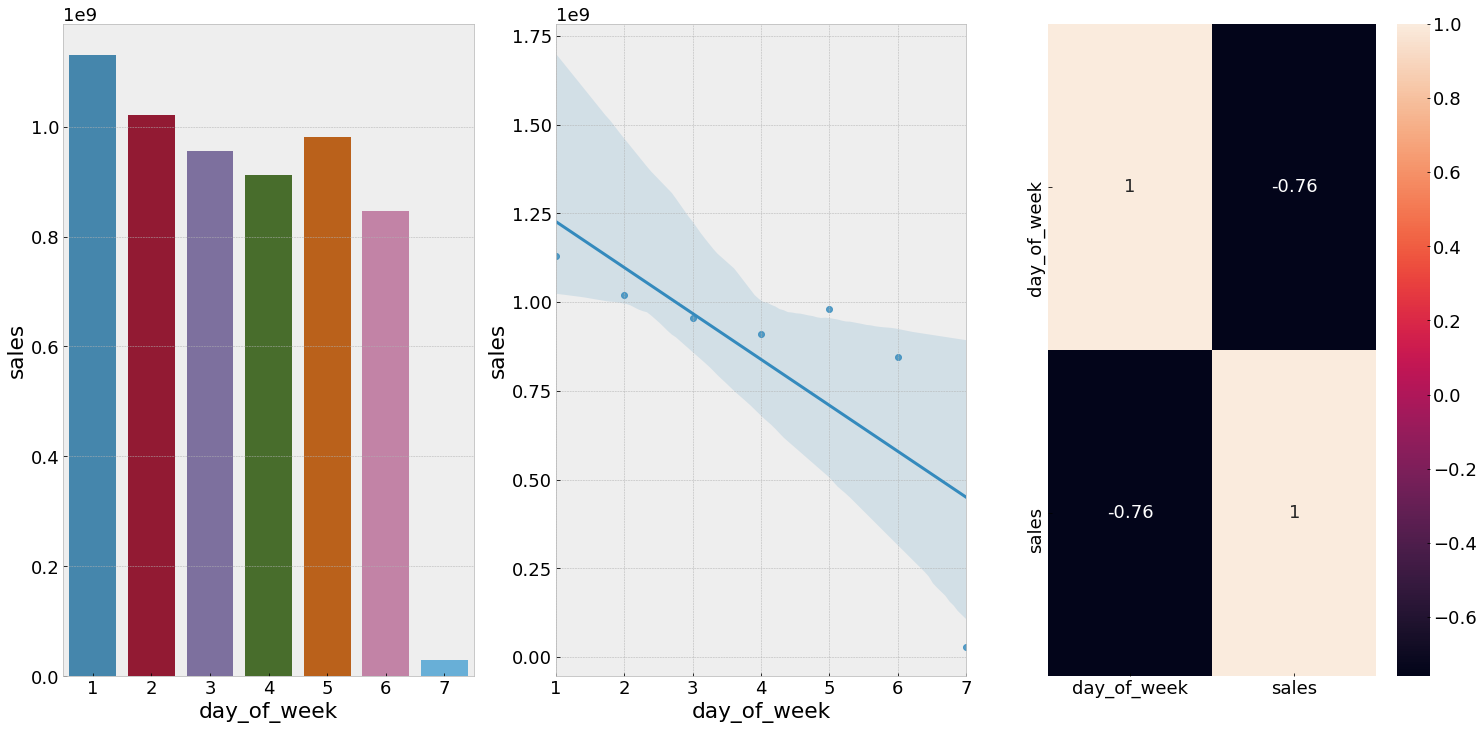

In [60]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### 4.2.11 H11: Lojas deveriam vender menos durante os feriados escolares.
**Verdadeiro:** lojas vendem menos durante os feriados escolares, exceto os meses de férias escolares

<AxesSubplot:xlabel='month', ylabel='sales'>

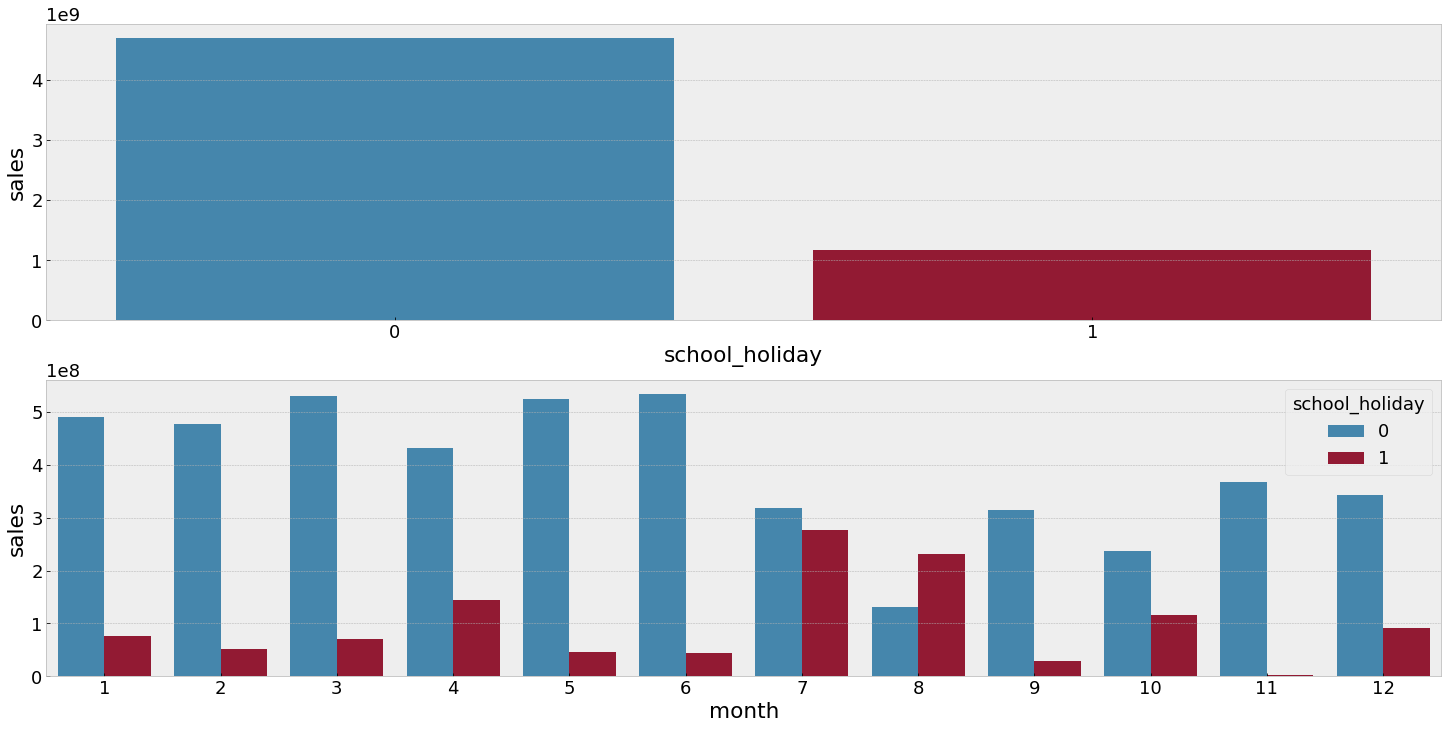

In [61]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1)

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2)

### 4.2.12 Resumo das hipóteses

In [62]:
from tabulate import tabulate

In [63]:
tab = [['Hipótese', 'Conclusão', 'Relevância'], 
       ['H1', 'Falsa', 'Baixa'], 
       ['H2', 'Falsa', 'Média'], 
       ['H3', 'Falsa', 'Média'], 
       ['H4', 'Falsa', 'Baixa'], 
       ['H5', 'Falsa', 'Baixa'], 
       ['H6', 'Falsa', 'Média'], 
       ['H7', 'Falsa', 'Alta'], 
       ['H8', 'Falsa', 'Alta'], 
       ['H9', 'Falsa', 'Alta'], 
       ['H10', 'Verdadeira', 'Alta'], 
       ['H11', 'Verdadeira', 'Baixa']
      ]
print(tabulate(tab, headers = 'firstrow'))

Hipótese    Conclusão    Relevância
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Média
H3          Falsa        Média
H4          Falsa        Baixa
H5          Falsa        Baixa
H6          Falsa        Média
H7          Falsa        Alta
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Baixa


## 4.3 Análise multivariada

### 4.3.1 Atributos numéricos

<AxesSubplot:>

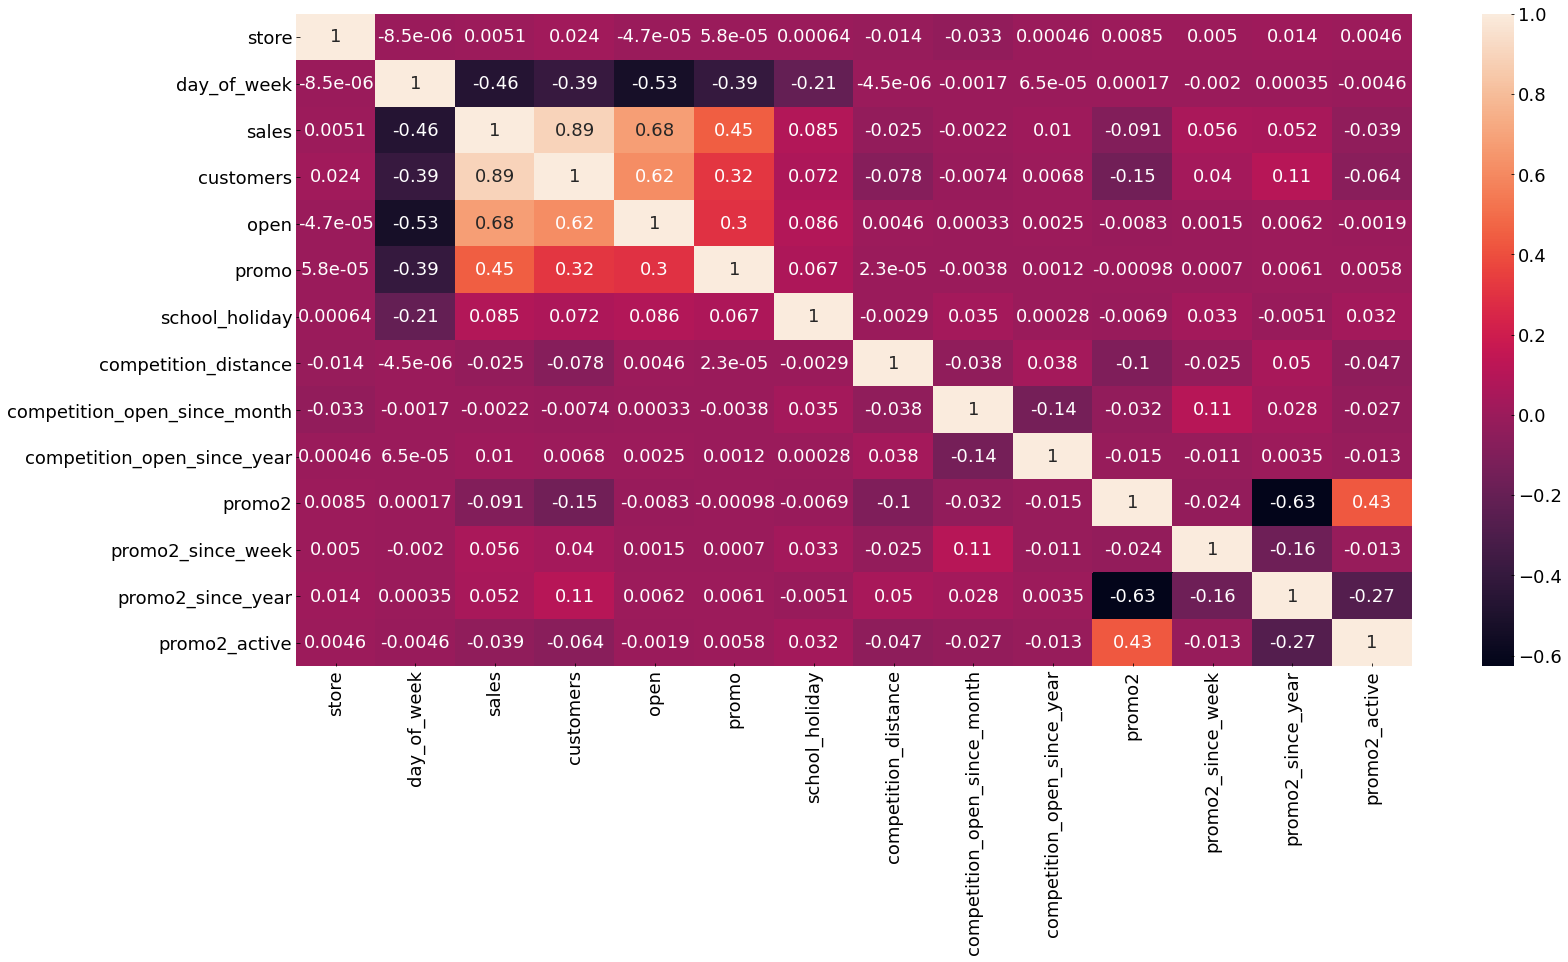

In [64]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

### 4.3.2 Atributos categóricos

<AxesSubplot:>

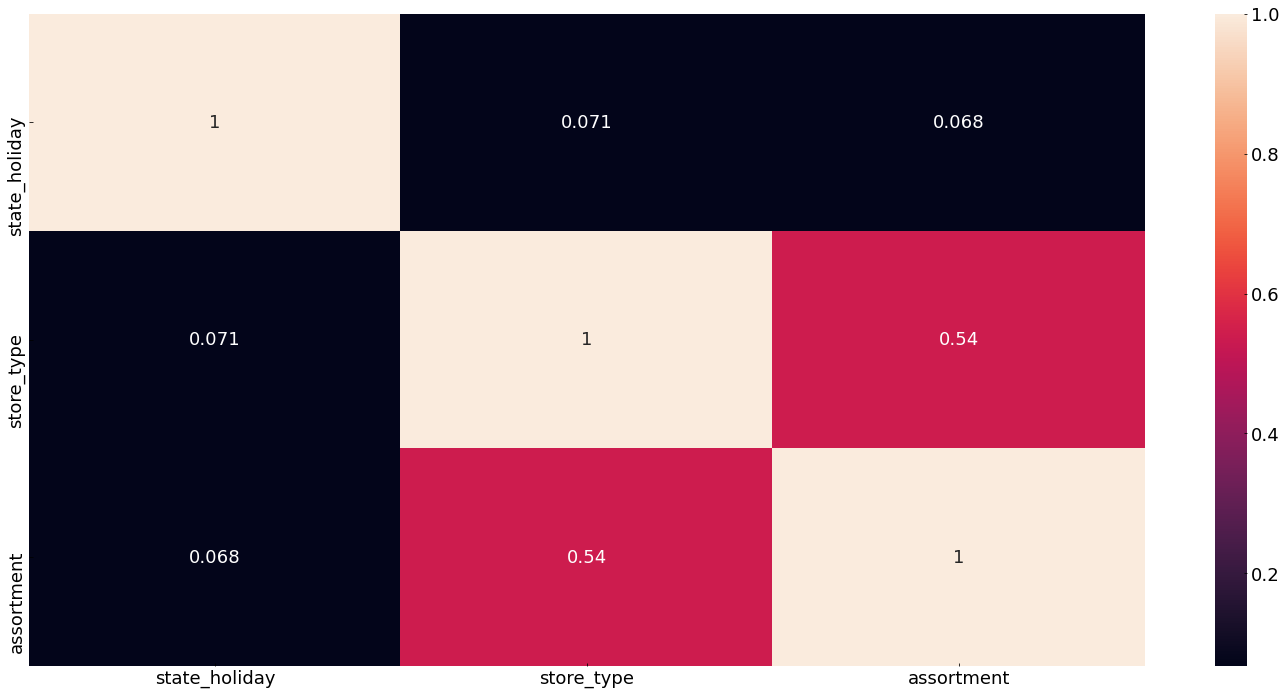

In [65]:
# Dados categóricos
cat = df4.select_dtypes(include = 'object')

# Cálculo do V de Cramér
a1 = cramerV(cat['state_holiday'], cat['state_holiday'])
a2 = cramerV(cat['state_holiday'], cat['store_type'])
a3 = cramerV(cat['state_holiday'], cat['assortment'])

a4 = cramerV(cat['store_type'], cat['state_holiday'])
a5 = cramerV(cat['store_type'], cat['store_type'])
a6 = cramerV(cat['store_type'], cat['assortment'])

a7 = cramerV(cat['assortment'], cat['state_holiday'])
a8 = cramerV(cat['assortment'], cat['store_type'])
a9 = cramerV(cat['assortment'], cat['assortment'])

# Conjunto final
d = pd.DataFrame({'state_holiday': [a1, a2, a3], 
                  'store_type': [a4, a5, a6], 
                  'assortment': [a7, a8, a9]})
d.set_index(d.columns, inplace = True)

sns.heatmap(d, annot = True)

# 5 Preparação dos dados

In [87]:
df5 = df4.copy()

## 5.0 Alguns métodos de preparação

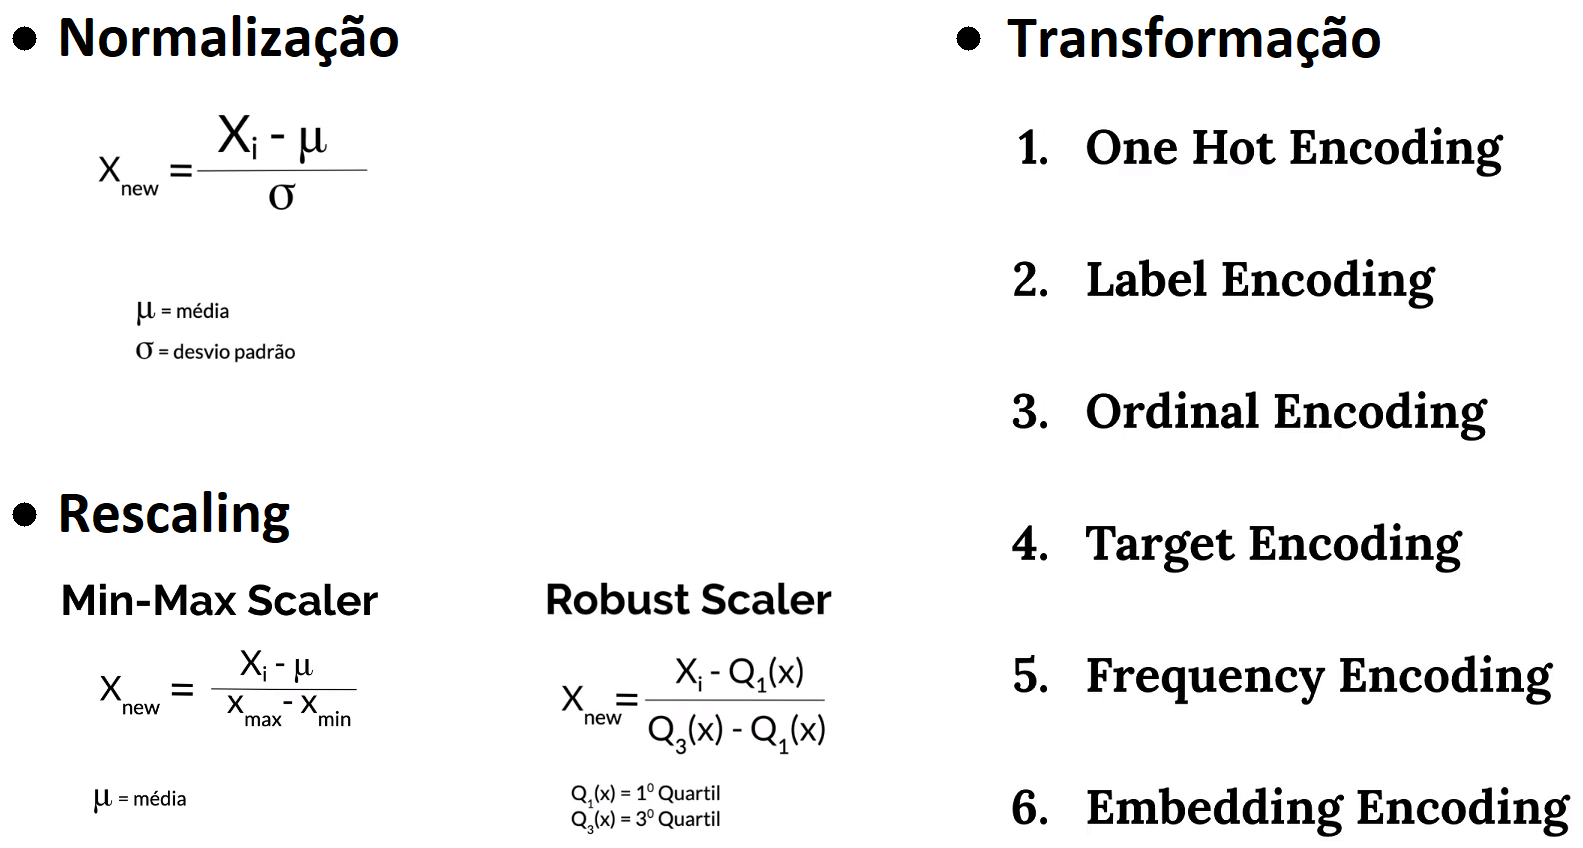

In [9]:
Image('img/DataPreparation.png')

## 5.1 Normalização

*Não há variáveis com distribuição normal*

## 5.2 Rescaling

In [7]:
rs = RobustScaler()
mms = MinMaxScaler()

# Competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# Competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# Promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# Year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

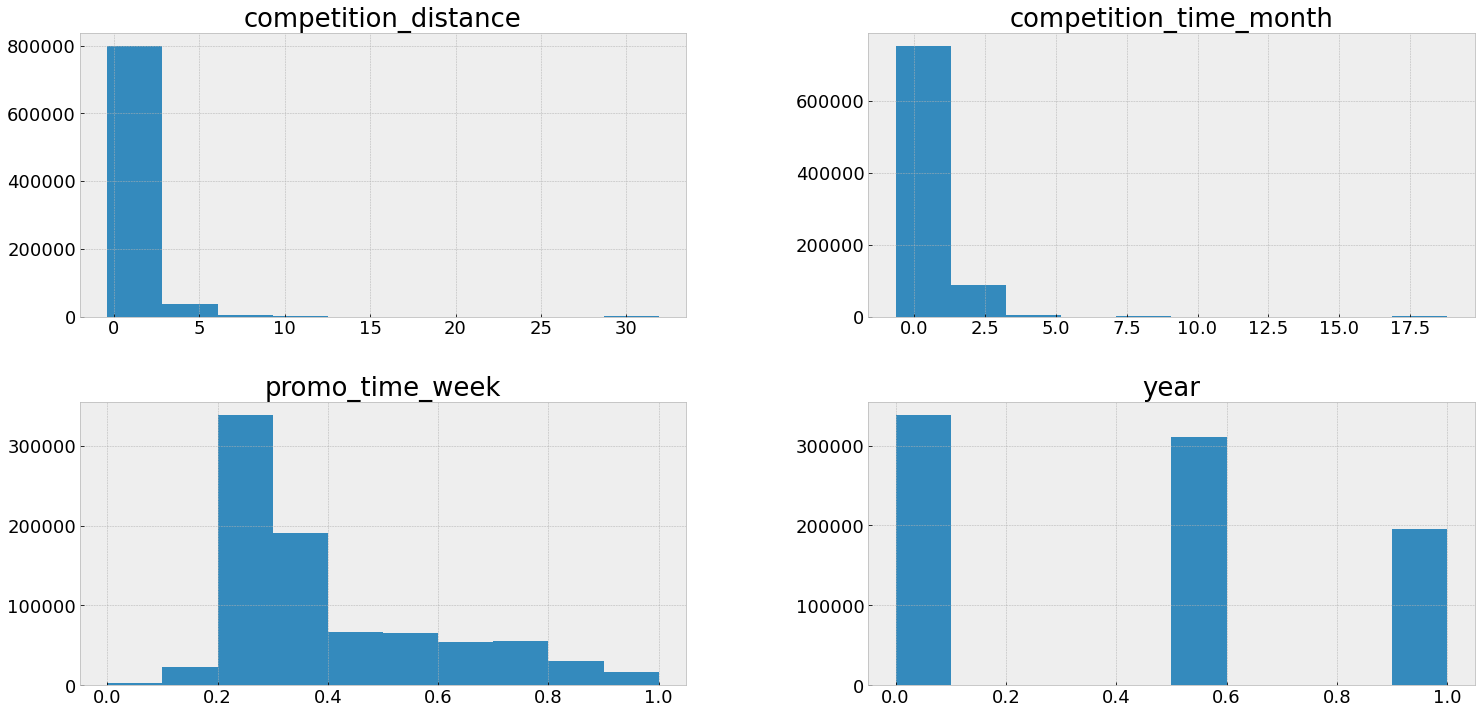

In [19]:
aux = df5[['competition_distance', 'competition_time_month', 'promo_time_week', 'year']]
aux.hist();

## 5.3 Transformação

### 5.3.1 Encoding

In [48]:
# state_holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - ordinal encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Transformação da variável resposta

In [21]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Transformação de natureza

In [22]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*2*np.pi/7))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*2*np.pi/7))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*2*np.pi/30))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*2*np.pi/30))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*2*np.pi/52))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*2*np.pi/52))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*2*np.pi/12))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*2*np.pi/12))

# 6 Seleção das features

In [23]:
df6 = df5.copy()

## 6.1 Separar dados para treino e teste

In [7]:
drop_cols = ['week_of_year', 'day', 'month', 'day_of_week', 'promo2_since', 'competition_since', 'year_week']
df6 = df6.drop(drop_cols, axis = 1)

In [8]:
data_final = df6[['store', 'date']].groupby('store').max()['date'].min()
data_final-datetime.timedelta(days = 6*7)

Timestamp('2015-05-29 00:00:00')

In [9]:
# X_train = df6[df6['date'] < '2015-05-29']
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Data min do treino: {}'.format(X_train['date'].min()))
print('Data max do treino: {}'.format(X_train['date'].max()))
print('\nData min do teste: {}'.format(X_test['date'].min()))
print('Data max do teste: {}'.format(X_test['date'].max()))

Data min do treino: 2013-01-01 00:00:00
Data max do treino: 2015-06-18 00:00:00

Data min do teste: 2015-06-19 00:00:00
Data max do teste: 2015-07-31 00:00:00


## 6.2 Seleção com Boruta

In [10]:
# Preparar os dados para o Boruta
X_train_b = X_train.drop(['date', 'sales'], axis = 1).values
y_train_b = y_train.values.ravel()

In [31]:
# rf = RandomForestRegressor(n_jobs = -1)
# boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_b, y_train_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


In [32]:
boruta.support_

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True, False, False, False,
       False,  True,  True,  True,  True, False,  True, False,  True])

In [52]:
# Características selecionadas
features_selected_boruta = X_train.drop(['date', 'sales'], axis = 1).loc[:,boruta.support_].columns.tolist()

# Características rejeitadas
features_not_selected_boruta = list(np.setdiff1d(X_train.drop(['date', 'sales'], axis = 1).columns, features_selected_boruta))

## 6.3 Seleção manual

In [10]:
features_selected_boruta = ['store', 
                            'promo', 
                            'store_type', 
                            'assortment', 
                            'competition_distance', 
                            'competition_open_since_month', 
                            'competition_open_since_year', 
                            'promo2', 
                            'promo2_since_week', 
                            'promo2_since_year', 
                            'competition_time_month', 
                            'promo_time_week', 
                            'day_of_week_sin', 
                            'day_of_week_cos', 
                            'day_sin', 
                            'day_cos', 
                            'week_of_year_sin', # Rejeitado pelo Boruta
                            'week_of_year_cos', 
                            'month_sin', # Rejeitado pelo Boruta
                            'month_cos']

# 7 Machine learning

In [11]:
x_train = X_train[features_selected_boruta]
x_test = X_test[features_selected_boruta]

In [12]:
# Dados para cross-validation
features_full = features_selected_boruta.copy()
features_full.extend(['date', 'sales'])
training = X_train[features_full]

## 7.1 Modelo de média

In [14]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'prediction'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
y_baseline = aux1['prediction']

# Performance
baseline_result = ml_error('Average model', np.expm1(y_test), np.expm1(y_baseline))
baseline_result

,model name,mae,mape,rmse
0,Average model,1354.800353,0.2064,1835.135542


## 7.2 Regressão linear

In [15]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction
y_pred_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear regression', np.expm1(y_test), np.expm1(y_pred_lr))
lr_result

,model name,mae,mape,rmse
0,Linear regression,1867.920466,0.292817,2672.640643


### 7.2.1 Cross-validation

In [20]:
lr_result_cv = cross_validation(training, 5, LinearRegression(), 'Linear regression', verbose = False)
lr_result_cv

,Model,MAE CV,MAPE CV,RMSE CV
0,Linear regression,2082.32 +- 295.81,0.3 +- 0.02,2953.32 +- 468.11


## 7.3 Regressão linear regularizada - Lasso

In [16]:
# Model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

# Prediction
y_pred_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear regression - Lasso', np.expm1(y_test), np.expm1(y_pred_lrr))
lrr_result

,model name,mae,mape,rmse
0,Linear regression - Lasso,1891.704881,0.289106,2744.451741


### 7.3.1 Cross-validation

In [21]:
lrr_result_cv = cross_validation(training, 5, Lasso(alpha = 0.01), 'Lasso', verbose = False)
lrr_result_cv

,Model,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +- 341.5,0.29 +- 0.01,3057.75 +- 504.26


## 7.4 Random forest regressor

In [22]:
# Model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

# Prediction
y_pred_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random forest regressor', np.expm1(y_test), np.expm1(y_pred_rf))
rf_result

,model name,mae,mape,rmse
0,Random forest regressor,679.852014,0.099978,1013.153321


### 7.4.1 Cross-validation

In [23]:
rf_result_cv = cross_validation(training, 5, RandomForestRegressor(), 'Random forest regressor', verbose = True)
rf_result_cv

kfold: 1
kfold: 2
kfold: 3
kfold: 4
kfold: 5


,Model,MAE CV,MAPE CV,RMSE CV
0,Random forest regressor,830.48 +- 197.86,0.12 +- 0.02,1241.66 +- 284.71


## 7.5 XGBoost regressor

In [17]:
# Model
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9).fit(x_train, y_train)

# Prediction
y_pred_xgb = xgb_model.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost regressor', np.expm1(y_test), np.expm1(y_pred_xgb))
xgb_result

[09:39:34] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,model name,mae,mape,rmse
0,XGBoost regressor,6683.20413,0.949427,7330.459043


### 7.5.1 Cross-validation

In [24]:
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9)
xgb_result_cv = cross_validation(training, 5, xgb_model, 'XGBoost regressor', verbose = True)
xgb_result_cv

kfold: 1
[11:16:29] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


kfold: 2
[11:17:34] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


kfold: 3
[11:18:33] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


kfold: 4
[11:19:29] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


kfold: 5
[11:20:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,Model,MAE CV,MAPE CV,RMSE CV
0,XGBoost regressor,7047.73 +- 587.68,0.95 +- 0.0,7713.74 +- 688.67


## 7.6 Comparação da performance

### 7.6.1 Performance única

In [25]:
modeling_results = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_results.sort_values('rmse')

,model name,mae,mape,rmse
0,Random forest regressor,679.852014,0.099978,1013.153321
0,Average model,1354.800353,0.206400,1835.135542
0,Linear regression,1867.920466,0.292817,2672.640643
0,Linear regression - Lasso,1891.704881,0.289106,2744.451741
0,XGBoost regressor,6683.204130,0.949427,7330.459043


### 7.6.2 Performance real | cross-validation

In [31]:
modeling_results_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modeling_results_cv.sort_values('RMSE CV')

,Model,MAE CV,MAPE CV,RMSE CV
0,Random forest regressor,830.48 +- 197.86,0.12 +- 0.02,1241.66 +- 284.71
0,Linear regression,2082.32 +- 295.81,0.3 +- 0.02,2953.32 +- 468.11
0,Lasso,2116.38 +- 341.5,0.29 +- 0.01,3057.75 +- 504.26
0,XGBoost regressor,7047.73 +- 587.68,0.95 +- 0.0,7713.74 +- 688.67


# 8 Ajuste fino dos hyperparâmetros

## 8.1 Método aleatório

In [23]:
params = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
          'eta': [0.01, 0.03],
          'max_depth': [3, 5, 9],
          'subsample': [0.1, 0.5, 0.7],
          'colsample_bytree': [0.3, 0.7, 0.9],
          'min_child_weight': [3, 8, 15]}
max_eval = 10

In [25]:
# final_result = pd.DataFrame()

# for i in range(max_eval):
#     # Choose parameters
#     hp = {k: random.choice(v) for k, v in params.items()}
#     print(i, hp)
    
#     # Model
#     xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                  n_estimators = hp['n_estimators'],
#                                  eta = hp['eta'],
#                                  max_depth = hp['max_depth'],
#                                  subsample = hp['subsample'],
#                                  colsample_bytree = hp['colsample_bytree'],
#                                  min_child_weight = hp['min_child_weight'])

#     # Performance
#     result = cross_validation(training, 5, xgb_model, 'XGBoost regressor', verbose = False)
#     final_result = pd.concat([final_result, result])
# final_result.reset_index(drop = True)

0 {'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}


C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users

1 {'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}


C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users

2 {'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}


C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users

3 {'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}


C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users

4 {'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}


C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users

5 {'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}


C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users

6 {'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}


C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users

7 {'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}


C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users

8 {'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}


C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users

9 {'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}


C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users

,Model,MAE CV,MAPE CV,RMSE CV
0,XGBoost regressor,851.86 +- 143.53,0.12 +- 0.01,1232.05 +- 204.47
1,XGBoost regressor,1684.72 +- 174.46,0.23 +- 0.01,2423.94 +- 231.66
2,XGBoost regressor,809.62 +- 134.24,0.11 +- 0.01,1169.55 +- 192.38
3,XGBoost regressor,909.34 +- 124.14,0.13 +- 0.01,1298.19 +- 170.65
4,XGBoost regressor,1777.11 +- 192.61,0.25 +- 0.01,2547.38 +- 260.08
5,XGBoost regressor,822.28 +- 131.15,0.12 +- 0.01,1181.04 +- 187.29
6,XGBoost regressor,1235.96 +- 137.24,0.17 +- 0.01,1782.74 +- 176.97
7,XGBoost regressor,1570.58 +- 167.34,0.22 +- 0.01,2269.16 +- 228.85
8,XGBoost regressor,967.3 +- 151.47,0.13 +- 0.01,1394.57 +- 207.41
9,XGBoost regressor,1794.49 +- 199.57,0.25 +- 0.01,2567.66 +- 270.4


## 8.2 Modelo final

In [ ]:
# 5 {'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}

In [13]:
tuned_params = {'n_estimators': 2500,
               'eta': 0.03,
               'max_depth': 9,
               'subsample': 0.1,
               'colsample_bytree': 0.9,
               'min_child_weight': 15}

In [14]:
# Model
xgb_model_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                   n_estimators = tuned_params['n_estimators'],
                                   eta = tuned_params['eta'],
                                   max_depth = tuned_params['max_depth'],
                                   subsample = tuned_params['subsample'],
                                   colsample_bytree = tuned_params['colsample_bytree'],
                                   min_child_weight = tuned_params['min_child_weight']).fit(x_train, y_train)

# Prediction
y_pred_xgb_tuned = xgb_model_tuned.predict(x_test)

# Performance
xgb_tuned_result = ml_error('XGBoost regressor', np.expm1(y_test), np.expm1(y_pred_xgb_tuned))
xgb_tuned_result

C:\Users\lucas\Anaconda3\envs\rossmann-store-sales\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,model name,mae,mape,rmse
0,XGBoost regressor,651.628566,0.094353,948.689893


In [17]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(y_pred_xgb_tuned))
mpe

0.0075965938507722725

In [19]:
# Salvando o modelo treinado
pickle.dump(xgb_model_tuned, open('model/rossmann_model.pkl', 'wb'))

# 9 Interpretação do erro

In [20]:
df9 = X_test[features_full]

# Reescalonamento
df9['sales'] = np.expm1(df9['sales'])
df9['prediction'] = np.expm1(y_pred_xgb_tuned)

<ipython-input-20-69d3641a9331>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
<ipython-input-20-69d3641a9331>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['prediction'] = np.expm1(y_pred_xgb_tuned)


## 9.1 Performance de negócio

In [8]:
# Soma das previsões
df91 = df9[['store', 'prediction']].groupby('store').sum().reset_index()

# MAE e MAPE
aux1 = df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['prediction'])).reset_index().rename(columns = {0: 'MAE'})
aux2 = df9[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['prediction'])).reset_index().rename(columns = {0: 'MAPE'})

# Merge
aux3 = pd.merge(aux1, aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, aux3, how = 'inner', on = 'store')

# Cenários
df92['worst_scenario'] = df92['prediction']-df92['MAE']
df92['best_scenario'] = df92['prediction']+df92['MAE']

df92 = df92[['store', 'prediction', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [9]:
df92.sort_values('MAPE', ascending = False).head()

,store,prediction,worst_scenario,best_scenario,MAE,MAPE
291,292,103639.4320,100255.943968,107022.920032,3383.488032,0.563634
908,909,237955.8321,230482.969322,245428.694878,7472.862778,0.505105
875,876,202722.8526,198748.830626,206696.874574,3974.021974,0.302222
721,722,352251.6854,350279.910119,354223.460681,1971.775281,0.262052
594,595,397300.1070,393734.893676,400865.320324,3565.213324,0.243511


<AxesSubplot:xlabel='store', ylabel='MAPE'>

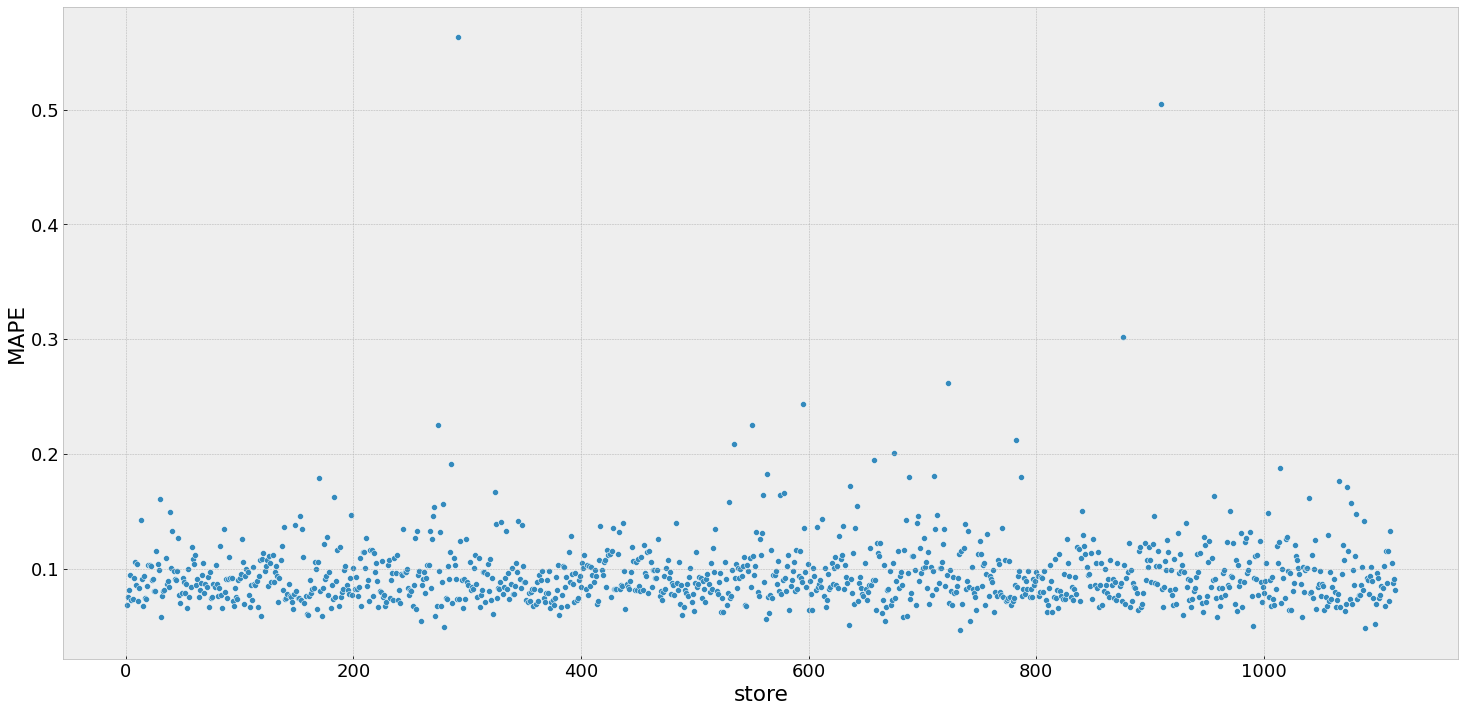

In [10]:
sns.scatterplot(x = 'store', y = 'MAPE', data = df92)

## 9.2 Performance total

In [11]:
df93 = df92[['prediction', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x)).reset_index().rename(columns = {'index': 'Scenario', 0: 'Value'})
df93['Value'] = df93['Value'].apply('R$ {:,.2f}'.format)
df93

,Scenario,Value
0,prediction,"R$ 282,430,958.64"
1,worst_scenario,"R$ 281,700,532.48"
2,best_scenario,"R$ 283,161,384.80"


## 9.3 Performance do modelo ML

In [24]:
df9['error'] = df9['sales']-df9['prediction']
df9['error_rate'] = df9['prediction']/df9['sales']

<AxesSubplot:xlabel='prediction', ylabel='error'>

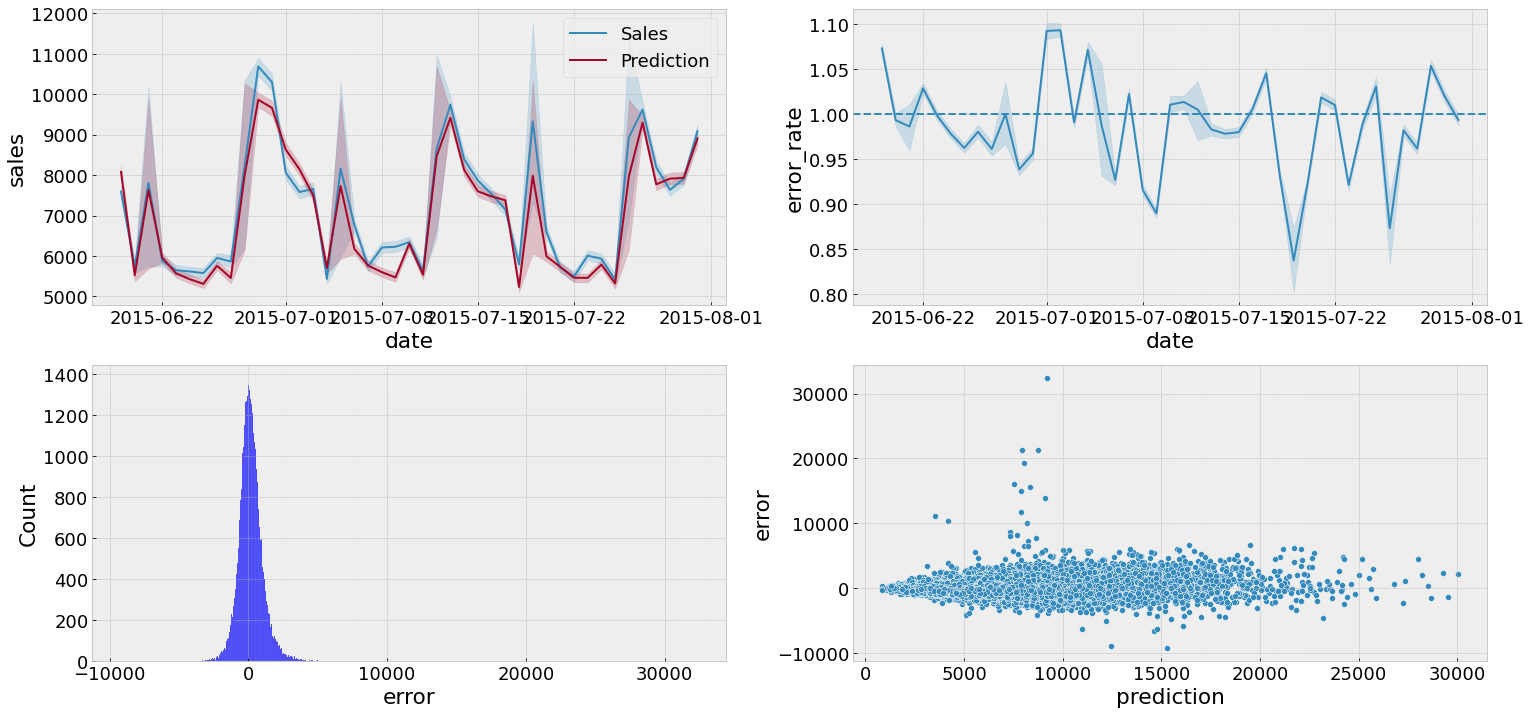

In [34]:
plt.subplot(2, 2, 1)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'Sales')
sns.lineplot(x = 'date', y = 'prediction', data = df9, label = 'Prediction')

plt.subplot(2, 2, 2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)
plt.axhline(1, ls = '--')

plt.subplot(2, 2, 3)
sns.histplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x = 'prediction', y = 'error', data = df9)

# 10 Deploy model to production

## 10.1 Classe Rossmann

In [9]:
import datetime
import inflection
import math
import numpy as np
import os
import pandas as pd
import pickle

class Rossmann(object):
    def __init__(self):
        self.home_path = 'C:/Users/lucas/Coding/DS/rossmann-store-sales'
        self.competition_distance_scaler = pickle.load(open(os.path.join(self.home_path, 'parameter/competition_distance_scaler.pkl'), 'rb'))
        self.competition_time_month_scaler = pickle.load(open(os.path.join(self.home_path, 'parameter/competition_time_month_scaler.pkl'), 'rb'))
        self.promo_time_week_scaler = pickle.load(open(os.path.join(self.home_path, 'parameter/promo_time_week_scaler.pkl'), 'rb'))
        self.year_scaler = pickle.load(open(os.path.join(self.home_path, 'parameter/year_scaler.pkl'), 'rb'))
        self.store_type_scaler = pickle.load(open(os.path.join(self.home_path, 'parameter/store_type_scaler.pkl'), 'rb'))
    
    def clean_data(self, df1):
        ## 1.1 Renomear colunas
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        df1.columns = cols_new
        
        ## 1.3 Tipos dos dados
        df1['date'] = pd.to_datetime(df1['date'])
        
        # Competition distance | replace with distance larger than previous max
        df1['competition_distance'].fillna(200000, inplace = True)
        
        # Competition open since month | replace with moth in date column
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
        
        # Competition open since year | replace with year in date column
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
        
        # Promo 2 since week | replace with week in date column
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
        
        # Promo 2 since year | replace with year in date column
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
        
        # Promo interval
        # Get month of date column in str format
        month_str = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['month_str'] = df1['date'].apply(lambda x: month_str[x.month])
        
        # 1: promo active, 0: otherwise
        df1['promo_interval'].fillna('-', inplace = True)
        df1['promo2_active'] = df1.apply(lambda x: 1 if x['month_str'] in x['promo_interval'].split(',') else 0, axis = 1)
        
        ## 1.5 Tipos dos dados
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    
    def feature_engineering(self, df2):
        ## 2.4 Criação das variáveis
        # Ano
        df2['year'] = df2['date'].apply(lambda x: x.year)
        
        # Mês
        df2['month'] = df2['date'].apply(lambda x: x.month)
        
        # Dia
        df2['day'] = df2['date'].apply(lambda x: x.day)
        
        # Semana
        df2['week_of_year'] = df2['date'].apply(lambda x: x.weekofyear)
        
        # Data | ano-semana
        df2['year_week'] = df2['date'].apply(lambda x: x.strftime('%Y-%W'))
        
        # Competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ((df2['date']-df2['competition_since'])).apply(lambda x: x.days/30).astype('int64')
        
        # Promo since
        df2['promo2_since'] = df2['promo2_since_year'].astype('str')+'-'+df2['promo2_since_week'].astype('str')
        df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%W'))
        df2['promo_time_week'] = (df2['date']-df2['promo2_since']).apply(lambda x: x.days/7).astype('int64')
        
        # Assortment | a = basic, b = extra, c = extended
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        
        # State holiday | a = public holiday, b = Easter holiday, c = Christmas, 0 = None
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day')
        
        # 3 Filtragem de variáveis
        ## 3.1 Filtragem das linhas
        df2 = df2[df2['open'] == 1]
        
        ## 3.2 Seleção das colunas
        drop_cols = ['open', 'promo_interval', 'month_str']
        df2.drop(drop_cols, axis = 1, inplace = True)
        
        return df2
    
    def data_preparation(self, df5):
        ## 5.2 Rescaling
        # Competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        # Competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        # Promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        # Year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        
        ### 5.3.1 Encoding
        # state_holiday - one hot encoding
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])
        
        # store_type - label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
        
        # assortment - ordinal encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        ### 5.3.3 Transformação de natureza
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*2*np.pi/7))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*2*np.pi/7))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*2*np.pi/30))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*2*np.pi/30))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*2*np.pi/52))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*2*np.pi/52))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*2*np.pi/12))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*2*np.pi/12))
        
        features_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 
                             'competition_open_since_month', 'competition_open_since_year', 'promo2', 
                             'promo2_since_week', 'promo2_since_year', 'competition_time_month', 
                             'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 
                             'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos']
        return df5[features_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # Prediction
        pred = model.predict(test_data)
        
        # Join original data and the prediction
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')

## 10.2 API handler

In [ ]:
import pandas as pd
import pickle

from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Load model
model = pickle.load(open('C:/Users/lucas/Coding/DS/rossmann-store-sales/model/rossmann_model.pkl', 'rb'))

# Initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:# Request returned data
        if isinstance(test_json, dict):# Unique json
            test_raw = pd.DataFrame(test_json, index = [0])
        else:# Multiple json
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
        
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # Data cleaning
        df1 = pipeline.clean_data(test_raw)
        
        # Feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # Data preparation
        df3 = pipeline.data_preparation(df2)
        
        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:# Request returned no data
        return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

## 10.3 API tester

In [10]:
import json
import requests

In [49]:
# Load test dataset
df10 = pd.read_csv('data/test.csv')
df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# Choose store for prediction
df_test = df_test[df_test['Store'].isin([12, 22, 24])]

# Remove days when store is closed
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)

In [50]:
# Convert dataframe to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [51]:
# API call
url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'http://127.0.0.1:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data = data, headers = header)
print('Status code {}'.format(r.status_code))

Status code 200


In [52]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

In [53]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()
for i in range(len(d2)):
    print('Store {} will sell R$ {:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store 12 will sell R$ 233,795.15 in the next 6 weeks
Store 22 will sell R$ 170,211.42 in the next 6 weeks
Store 24 will sell R$ 299,431.75 in the next 6 weeks


# Atalho

## Exportar dados

In [44]:
num_attributes.to_csv('C:/Users/Lucas/Coding/DS/Kaggle/num_attributes.csv', index = False)

In [45]:
cat_attributes.to_csv('C:/Users/Lucas/Coding/DS/Kaggle/cat_attributes.csv', index = False)

In [47]:
m.to_csv('C:/Users/Lucas/Coding/DS/Kaggle/m.csv', index = False)

In [22]:
df9.to_csv('C:/Users/Lucas/Coding/DS/Kaggle/df9.csv', index = False)

## Importar dados

In [5]:
num_attributes = pd.read_csv('C:/Users/Lucas/Coding/DS/data-shortcut/rossmann-store-sales/num_attributes.csv')

In [6]:
cat_attributes = pd.read_csv('C:/Users/Lucas/Coding/DS/data-shortcut/rossmann-store-sales/cat_attributes.csv')

In [7]:
m = pd.read_csv('C:/Users/Lucas/Coding/DS/data-shortcut/rossmann-store-sales/m.csv')

In [6]:
df5 = pd.read_csv('C:/Users/Lucas/Coding/DS/data-shortcut/rossmann-store-sales/df5.csv')
df5['date'] = pd.to_datetime(df5['date'])
df5['competition_since'] = pd.to_datetime(df5['competition_since'])
df5['promo2_since'] = pd.to_datetime(df5['promo2_since'])

In [6]:
df6 = pd.read_csv('C:/Users/Lucas/Coding/DS/data-shortcut/rossmann-store-sales/df6.csv')
df6['date'] = pd.to_datetime(df6['date'])
df6['competition_since'] = pd.to_datetime(df6['competition_since'])
df6['promo2_since'] = pd.to_datetime(df6['promo2_since'])

In [6]:
df9 = pd.read_csv('C:/Users/Lucas/Coding/DS/data-shortcut/rossmann-store-sales/df9.csv')
df9['date'] = pd.to_datetime(df9['date'])